In [1]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import cv2
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
from tqdm.notebook import tqdm
from scipy import ndimage
import skimage
import skimage.filters

from torchvision.transforms import functional as F

from IPython.display import display, Markdown

from simple_relational_reasoning.embeddings.stimuli import build_differet_shapes_stimulus_generator, build_split_text_stimulus_generator, build_random_color_stimulus_generator,\
    find_non_empty_indices, EMPTY_TENSOR_PIXEL
from simple_relational_reasoning.embeddings.triplets import QuinnTripletGenerator, ABOVE_BELOW_RELATION, BETWEEN_RELATION

In [2]:

FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight', should_print=False, should_prefix=True):
    if save_path is not None:
        save_path = os.path.abspath(save_path)
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX) and should_prefix:
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [3]:
reference_positions = [(105, 100)]

def plot_generator_examples(generator, ref_pos=reference_positions):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((80, 100 + (i * 20)), ref_pos, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

def plot_triplets(triplets):
    n = triplets.shape[0]
    k = triplets.shape[1]

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

            if row == 0:
                if col == k - 1:
                    ax.set_title('Different Relation')
                elif col == k - 2:
                    ax.set_title('Same Relation')
                else:
                    ax.set_title(f'Habituation #{col + 1}')

    fig.tight_layout()

    plt.show()

def plot_cropped_centered_triplets(triplets, canvas_size=(3, 200, 200), edge_color=(1, 0, 0)):
    n = triplets.shape[0]
    k = triplets.shape[1]

    if not isinstance(edge_color, torch.Tensor):
        edge_color = torch.tensor(edge_color, dtype=torch.float32).view(3, 1)

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            img = triplets[row, col]
            r1, r2, c1, c2 = find_non_empty_indices(img, EMPTY_TENSOR_PIXEL, color_axis=0)
            img = img[:, r1:r2, c1:c2]
            canvas = torch.ones(*canvas_size)
            h = r2 - r1
            w = c2 - c1
            h_start = torch.div(canvas_size[1] - h, 2, rounding_mode='floor')
            w_start = torch.div(canvas_size[2] - w, 2, rounding_mode='floor')
            canvas[:, h_start:h_start + h, w_start:w_start + w] = img
            canvas[:, h_start - 1, w_start:w_start + w] = edge_color
            canvas[:, h_start + h, w_start:w_start + w] = edge_color
            canvas[:, h_start:h_start + h, w_start - 1] = edge_color
            canvas[:, h_start:h_start + h, w_start + w] = edge_color
            ax.imshow(canvas.permute(1, 2, 0).numpy())

            ax.set_title(f'{h} x {w} = {h * w}')

    fig.tight_layout()

    plt.show()

FLIPS = (
    lambda x: x,
    F.hflip,
    F.vflip,
    lambda x: F.hflip(F.vflip(x))
)

FLIP_NAMES = ('None', 'Horizontal', 'Vertical', 'Both')


def plot_flipped_versions(base_images, base_image_names, save_path=None,
    flips=FLIPS, flip_names=FLIP_NAMES, text_kwargs=None):

    if text_kwargs is None:
        text_kwargs = {}
    
    k = len(base_images)
    n = len(flips)

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            ax.imshow(flips[row](base_images[col]).permute(1, 2, 0).numpy())

            if row == 0:
                ax.set_title(base_image_names[col], **text_kwargs)

            if col == 0:
                ax.set_ylabel(flip_names[row], **text_kwargs)

    fig.tight_layout()

    if save_path is not None:
        save_plot(save_path, should_prefix=False)

    plt.show()


GENERATOR_NAMES = ('color bar', 'split text', 'random colors')


def create_stimulus_generators_and_names(names=GENERATOR_NAMES, seed=None, **kwargs):
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))

    generators = (
        build_differet_shapes_stimulus_generator(reference_size=(10, 140), rng=rng, 
        # blur_func=lambda x: cv2.blur(x, (7, 7)), 
        # blur_func=lambda x: skimage.filters.gaussian(x, sigma=1, channel_axis=-1),
        **kwargs), 
        
        build_split_text_stimulus_generator(
            # reference_box_size=10,
            # total_reference_size=(10, 140), n_reference_patches=8,
            # reference_patch_kwargs=dict(ylim=(-70, 70)),
            rng=rng, **kwargs),
        build_random_color_stimulus_generator(reference_size=(10, 140), rng=rng, **kwargs)
    )
    
    return zip(generators, names)

In [4]:
BASELINE_TRIPLET_KWARGS = dict(n_target_types=2, extra_diagonal_margin=0)
distance_endpoints_dict = {
    (False, False): (30, 80),
    (True, False): (80, 120),
    (True, True): (40, 80),  
}

# Stimulus conditions we have
* Above/below
    * With two reference objects
        * With or without a gap between them
* Between
* *The above two relations, but sideways (left/right and vertical between)* -- currently not plotted because it's just the regular stimuli transposed, but I can add that demo.
* Diagonal
* With both generators above



# Above/Below

## color bar | above_below | one ref

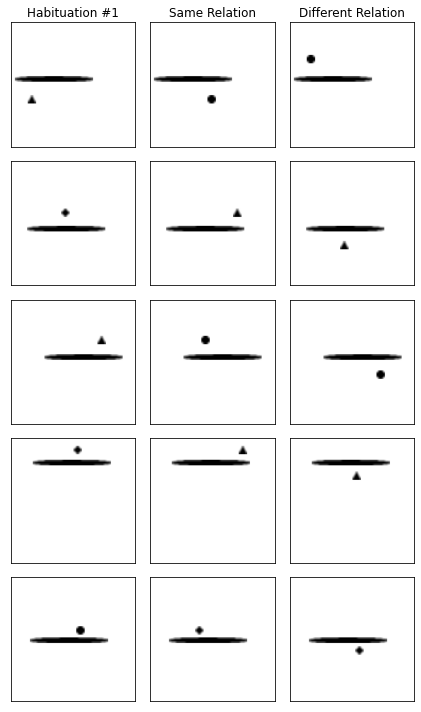

----

## split text | above_below | one ref

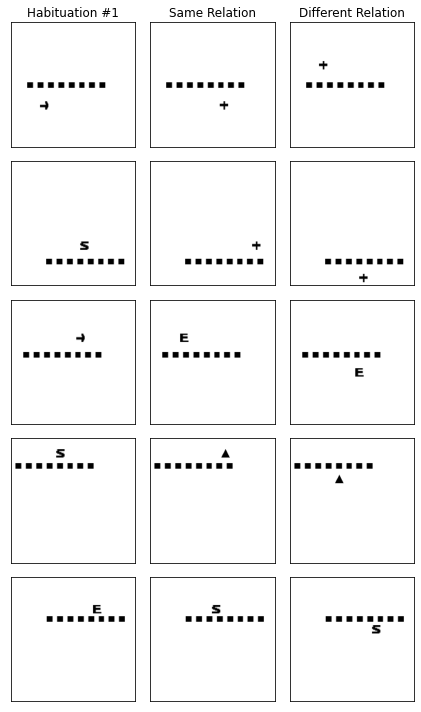

----

## random colors | above_below | one ref

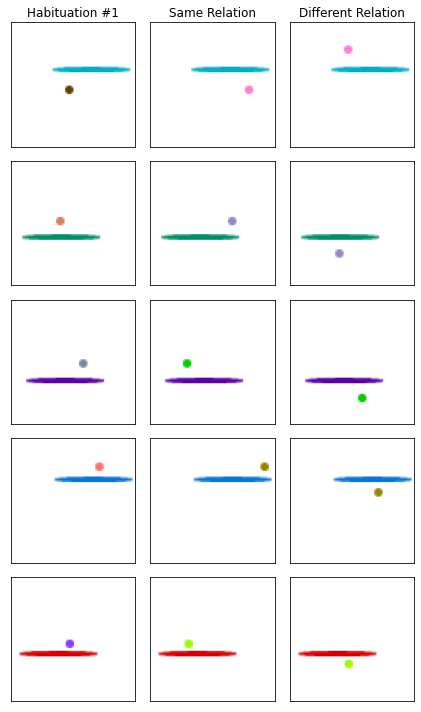

----

## color bar | above_below | two refs | non-adjacent refs

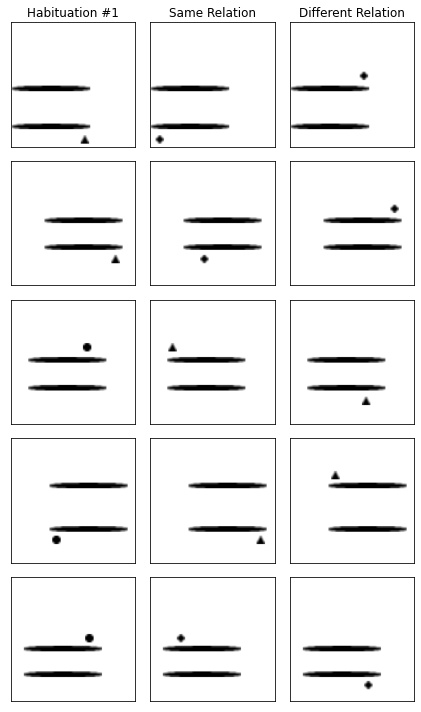

----

## split text | above_below | two refs | non-adjacent refs

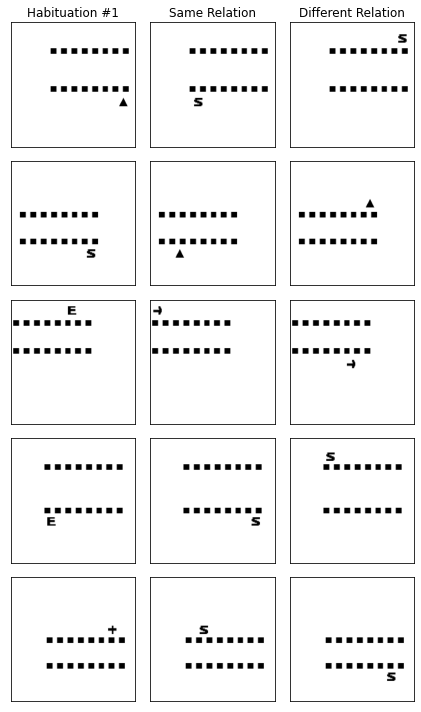

----

## random colors | above_below | two refs | non-adjacent refs

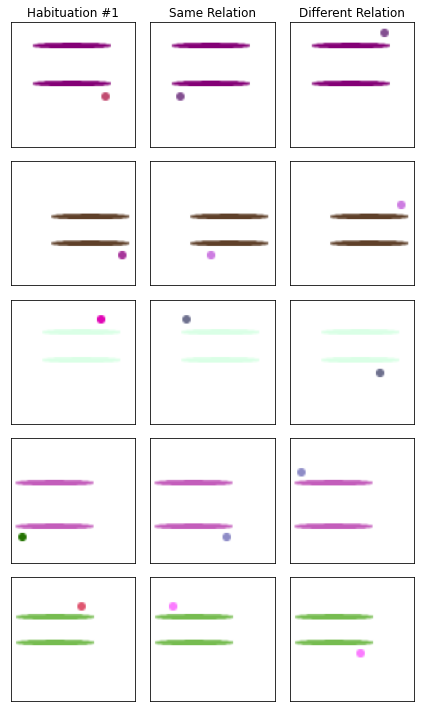

----

## color bar | above_below | two refs | adjacent refs

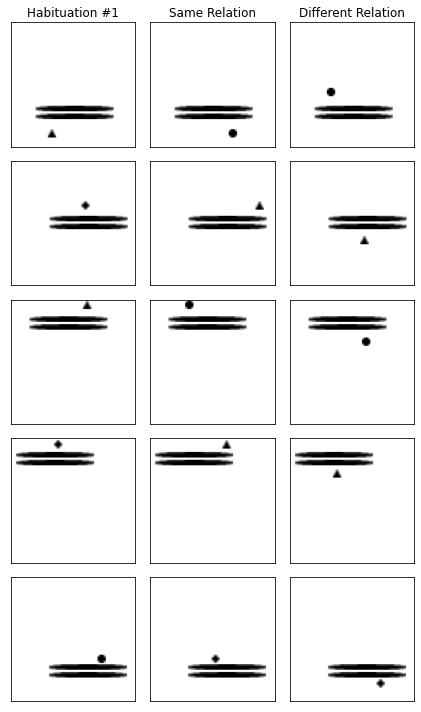

----

## split text | above_below | two refs | adjacent refs

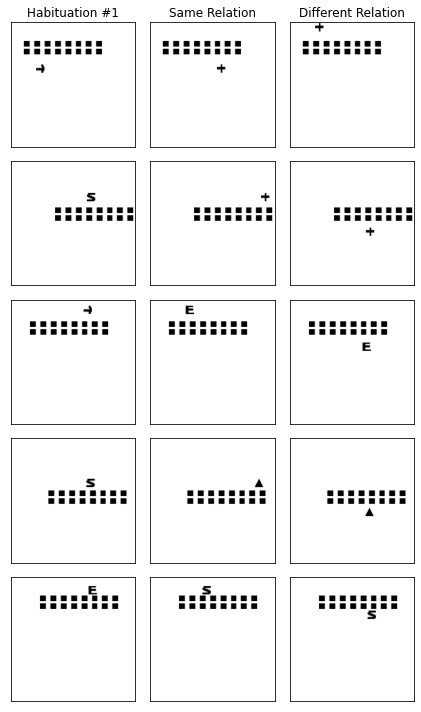

----

## random colors | above_below | two refs | adjacent refs

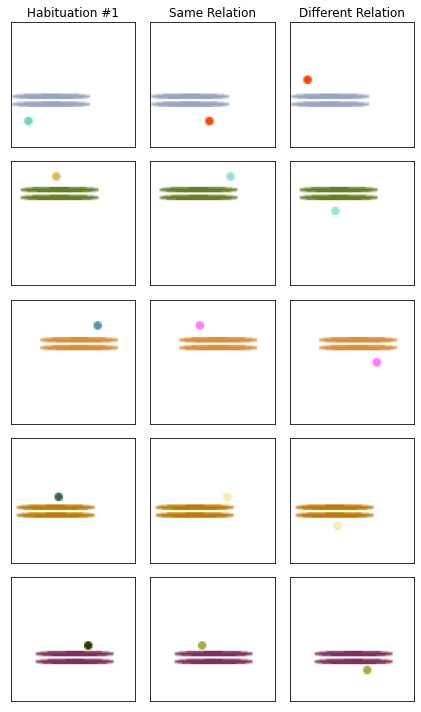

----

In [5]:
relation = ABOVE_BELOW_RELATION
N_examples = 5

display(Markdown('# Above/Below'))

for two_reference_objects in (False, True):
    for adjacent_reference_objects in (False, True):
        if not two_reference_objects and adjacent_reference_objects:
            continue

        distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

        for stimulus_generator, generator_name in create_stimulus_generators_and_names():
            
            triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
                relation=relation, two_reference_objects=two_reference_objects,
                adjacent_reference_objects=adjacent_reference_objects, **BASELINE_TRIPLET_KWARGS)

            adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
            title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
            display(Markdown(f'## {title}'))
            triplets = triplet_generator(N_examples, normalize=False)
            plot_triplets(triplets)
            display(Markdown('----'))


# Between/Outside

## color bar | between

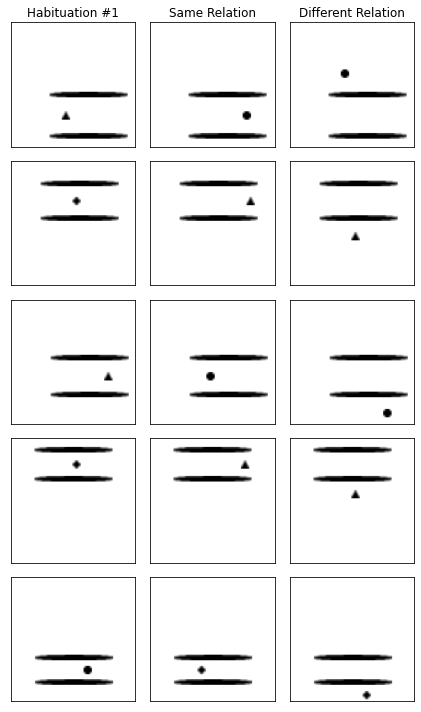

----

## split text | between

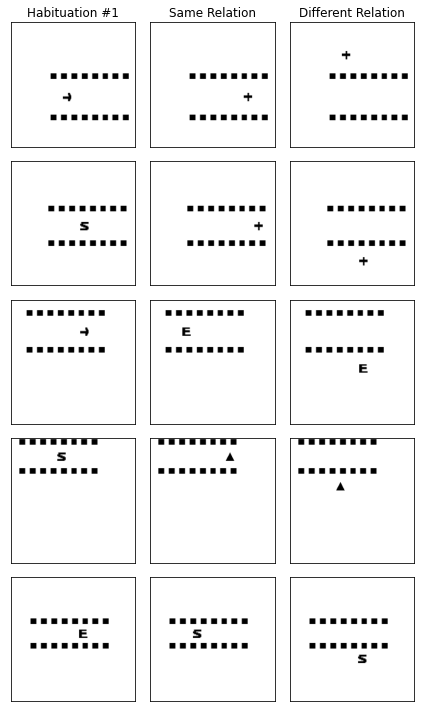

----

## random colors | between

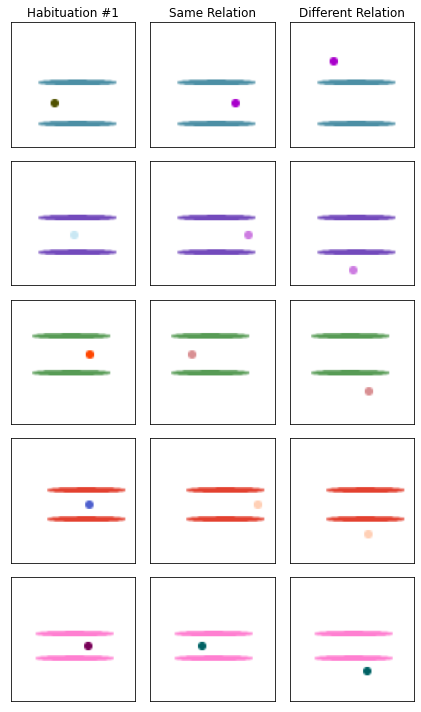

----

In [6]:
relation = BETWEEN_RELATION
distance_endpoints = distance_endpoints_dict[(True, False)]
N_examples = 5

display(Markdown('# Between/Outside'))

distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for stimulus_generator, generator_name in create_stimulus_generators_and_names():
    
    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=True,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
    # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
    title = f'{generator_name} | {relation}'
    display(Markdown(f'## {title}'))
    triplets = triplet_generator(N_examples, normalize=False)
    plot_triplets(triplets)
    display(Markdown('----'))


# Diagonal Above/Below

## color bar | above_below | 30 degrees

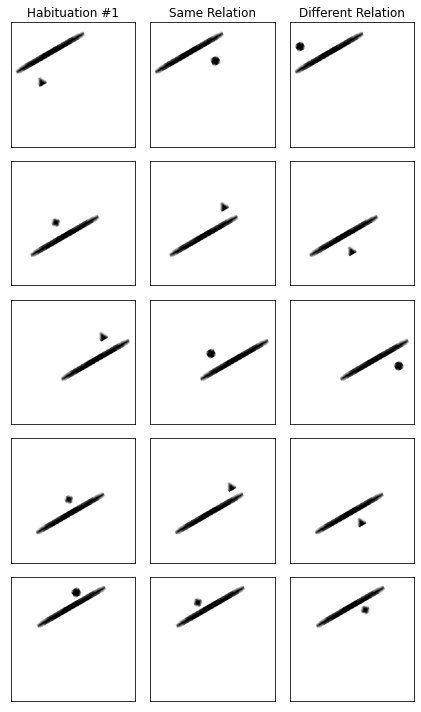

----

## split text | above_below | 30 degrees

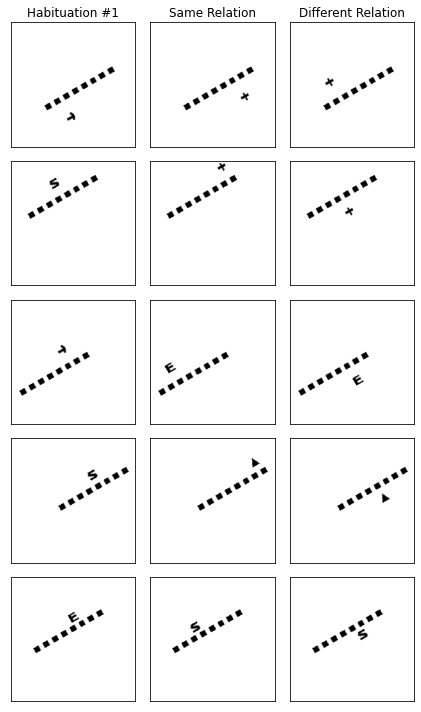

----

## random colors | above_below | 30 degrees

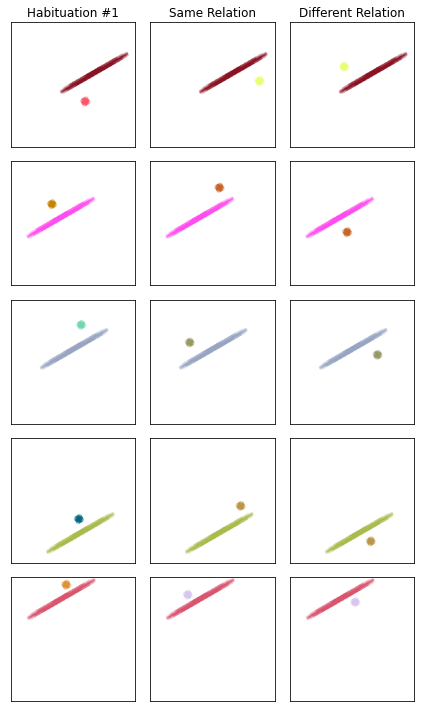

----

## color bar | above_below | 45 degrees

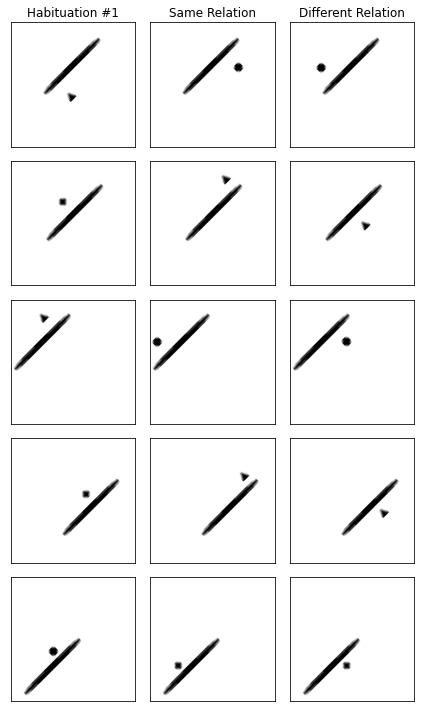

----

## split text | above_below | 45 degrees

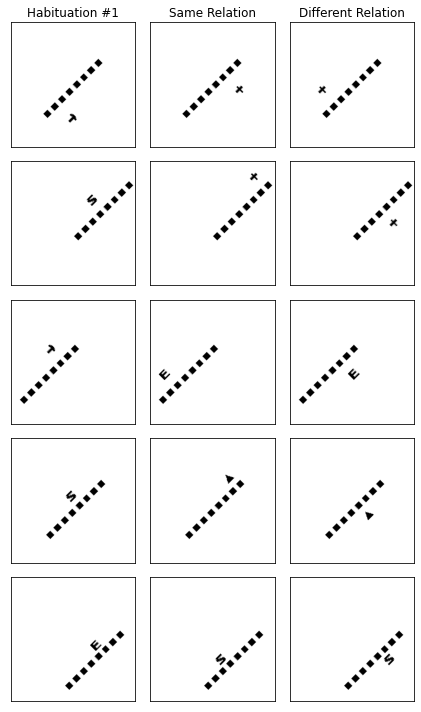

----

## random colors | above_below | 45 degrees

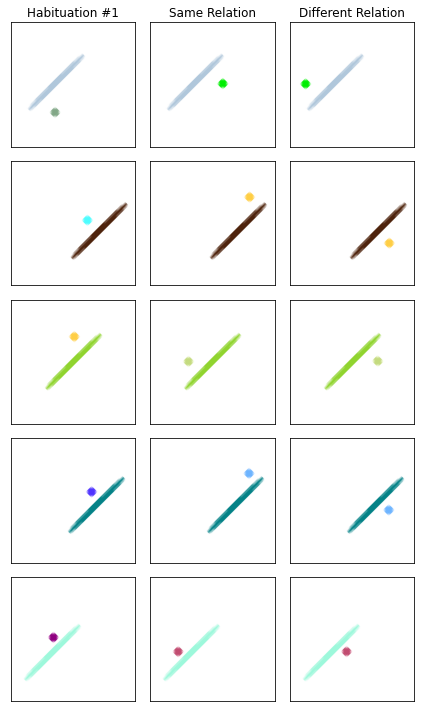

----

## color bar | above_below | 60 degrees

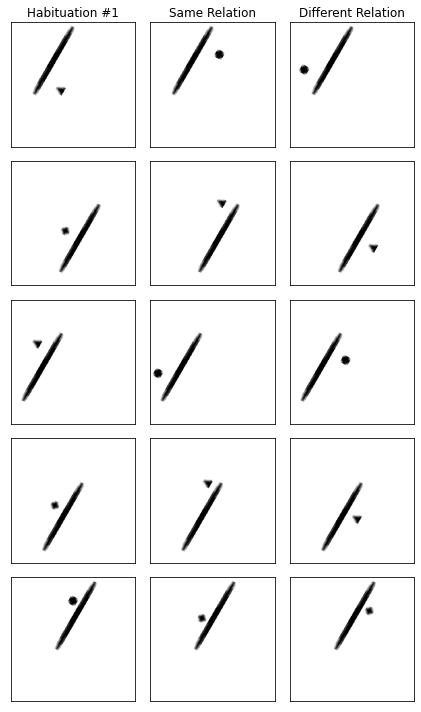

----

## split text | above_below | 60 degrees

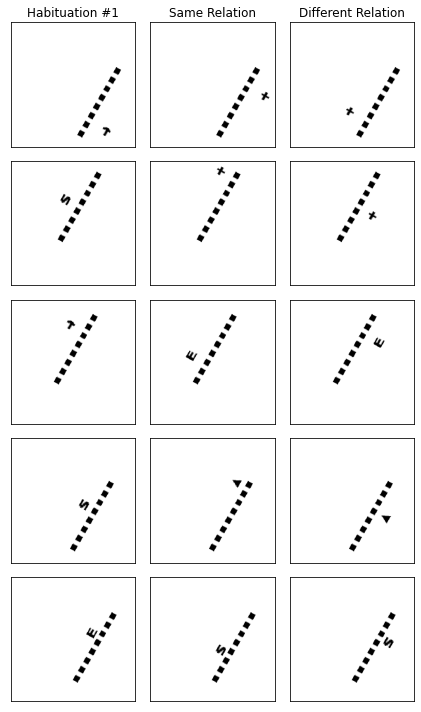

----

## random colors | above_below | 60 degrees

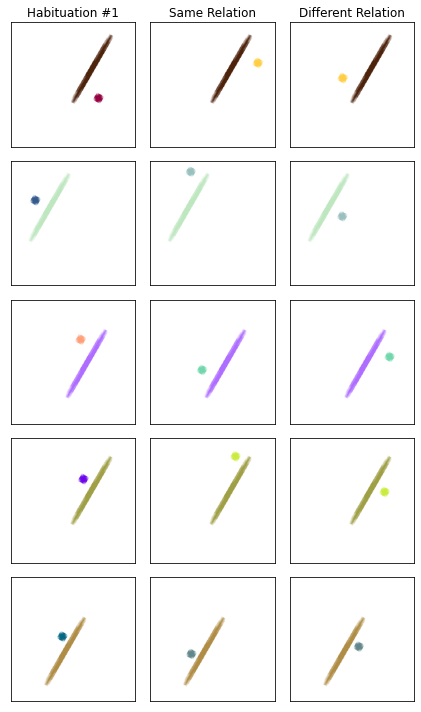

----

## color bar | above_below | 90 degrees

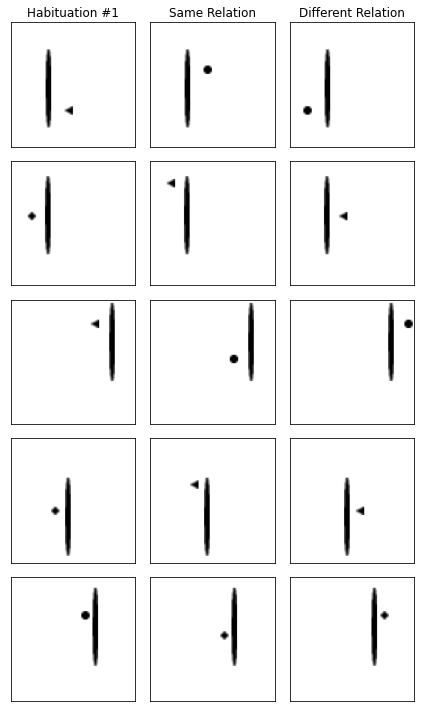

----

## split text | above_below | 90 degrees

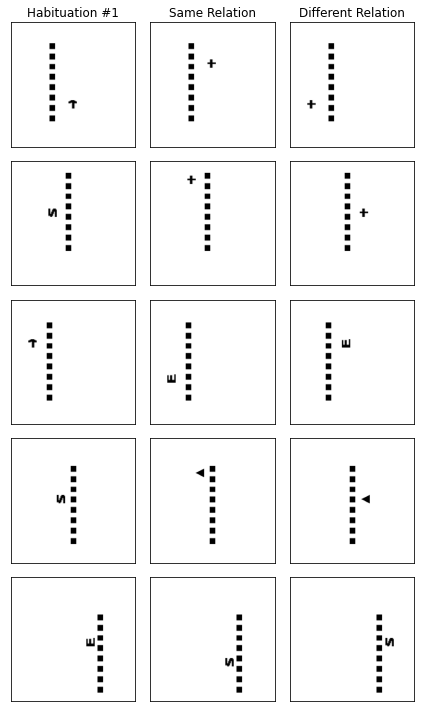

----

## random colors | above_below | 90 degrees

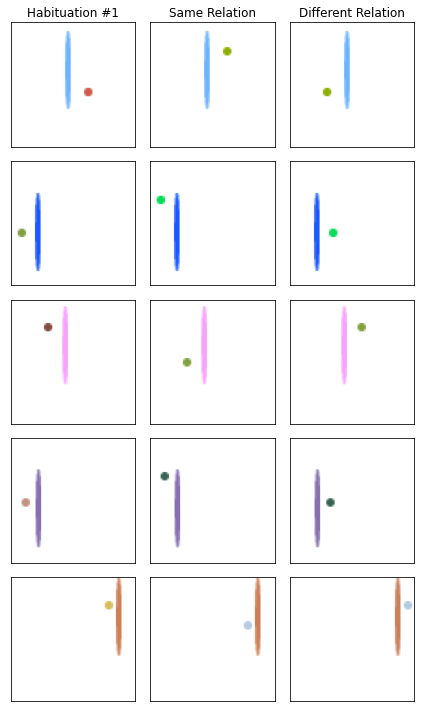

----

## color bar | above_below | 120 degrees

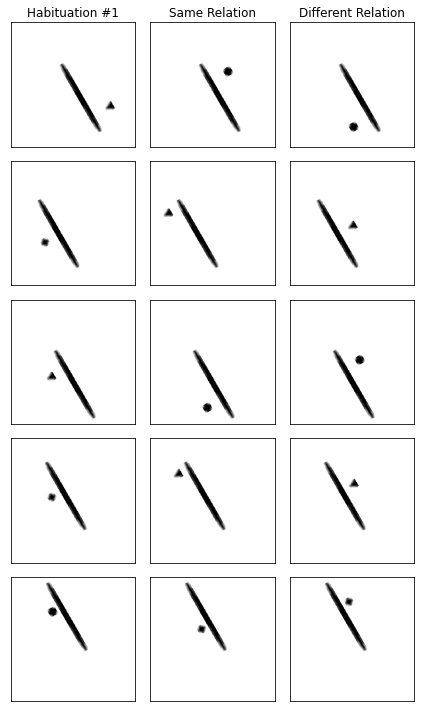

----

## split text | above_below | 120 degrees

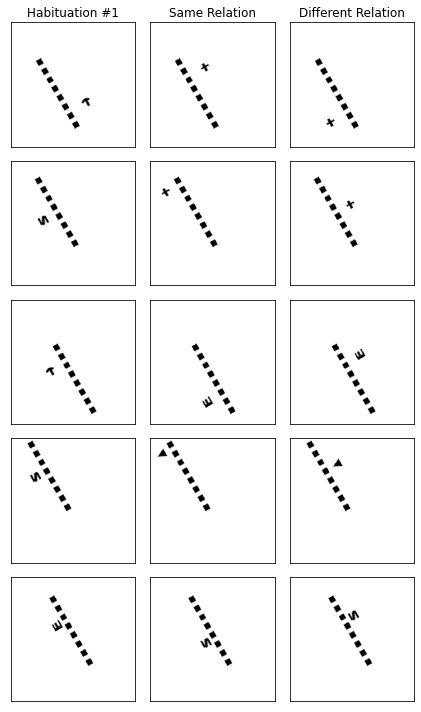

----

## random colors | above_below | 120 degrees

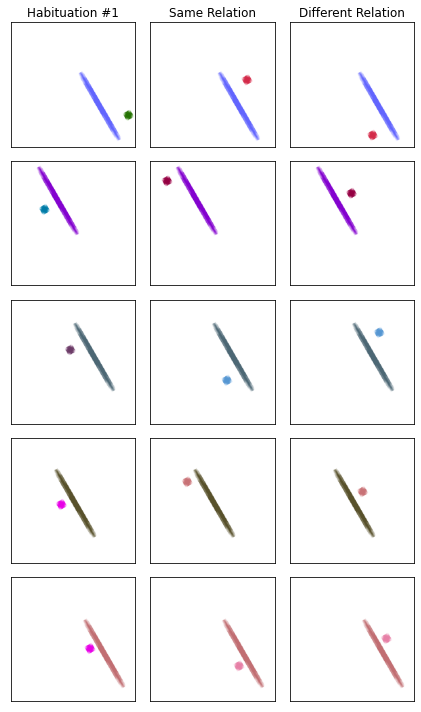

----

## color bar | above_below | 135 degrees

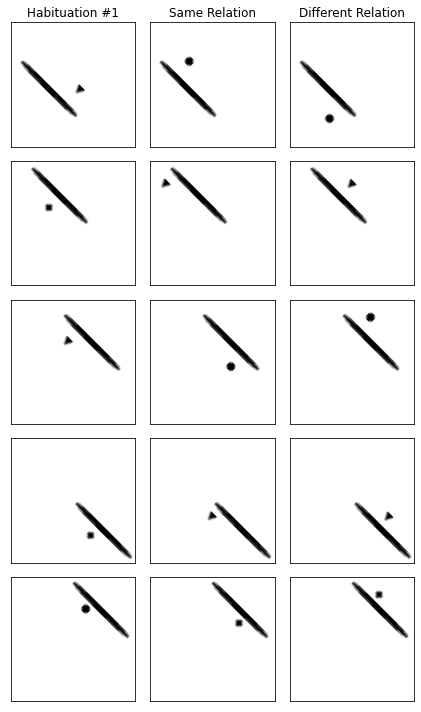

----

## split text | above_below | 135 degrees

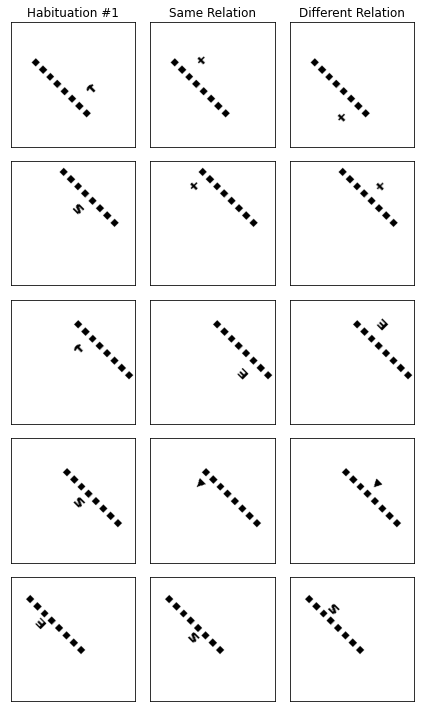

----

## random colors | above_below | 135 degrees

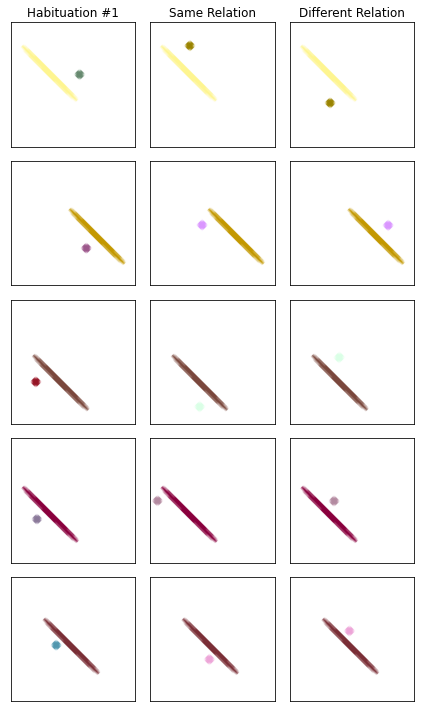

----

## color bar | above_below | 150 degrees

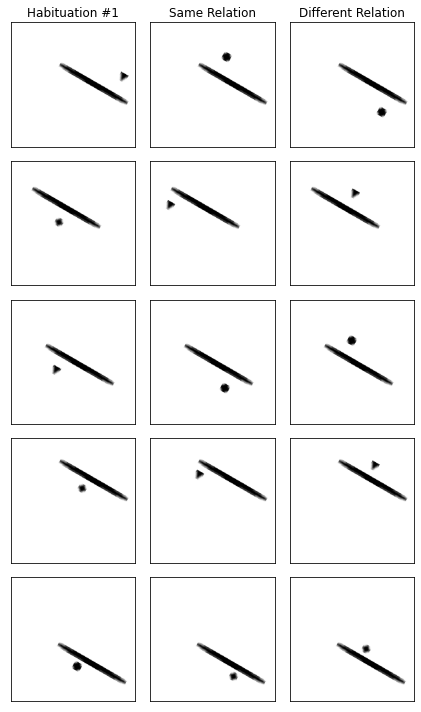

----

## split text | above_below | 150 degrees

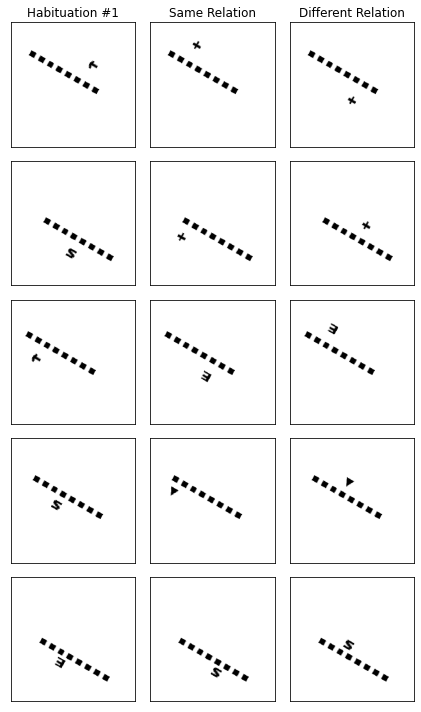

----

## random colors | above_below | 150 degrees

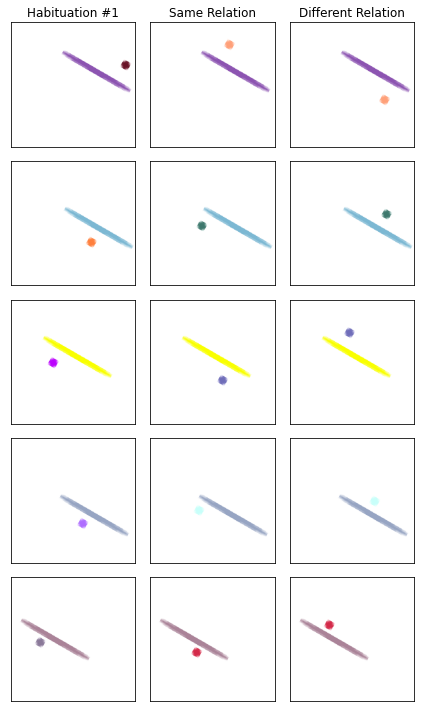

----

In [7]:
relation = ABOVE_BELOW_RELATION
distance_endpoints = distance_endpoints_dict[(False, False)]
N_examples = 5

display(Markdown('# Diagonal Above/Below'))

# distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for rotate_angle in (30, 45, 60, 90, 120, 135, 150):
    for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
        
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=False,
            adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

        # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
        # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
        title = f'{generator_name} | {relation} | {rotate_angle} degrees'
        display(Markdown(f'## {title}'))
        triplets = triplet_generator(N_examples, normalize=False)
        plot_triplets(triplets)
        display(Markdown('----'))


# Multiple Habituation Stimuli

## 4 habituation stimuli

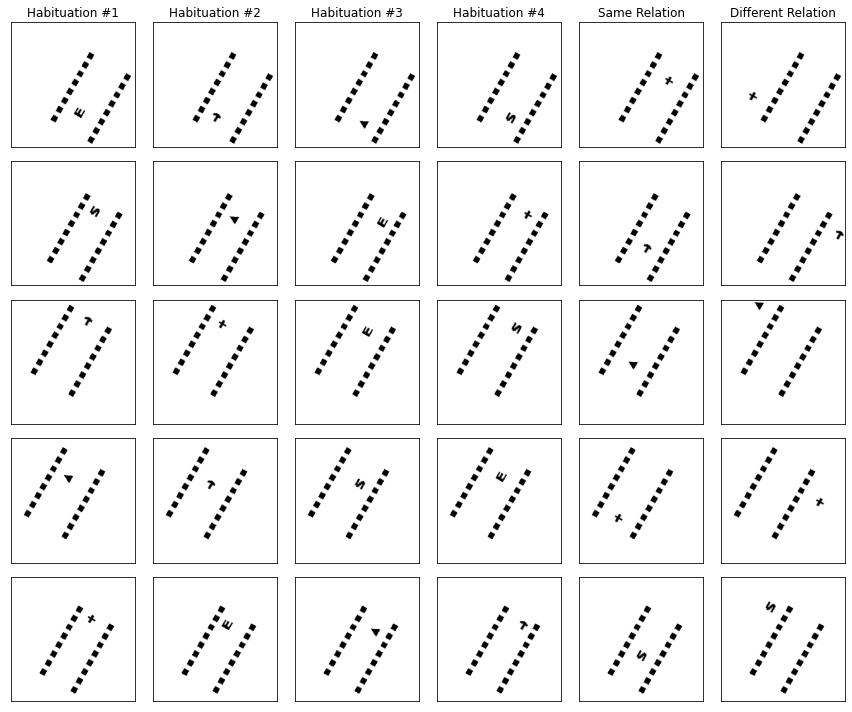

----

In [8]:
relation = BETWEEN_RELATION
distance_endpoints = (40, 80)
N_examples = 5
n_habituation_stimuli = 4

display(Markdown('# Multiple Habituation Stimuli'))

rng = np.random.default_rng(n_habituation_stimuli)
stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=60)
# stimulus_generator = build_random_color_stimulus_generator(rng=rng)

triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
    relation=relation, two_reference_objects=True, 
    adjacent_reference_objects=False, n_habituation_stimuli=n_habituation_stimuli,
    **BASELINE_TRIPLET_KWARGS)

# adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
# title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
title = f'{n_habituation_stimuli} habituation stimuli'
display(Markdown(f'## {title}'))
triplets = triplet_generator(N_examples, normalize=False)
plot_triplets(triplets)
display(Markdown('----'))


## Flipping Manipulation -- Above/Below

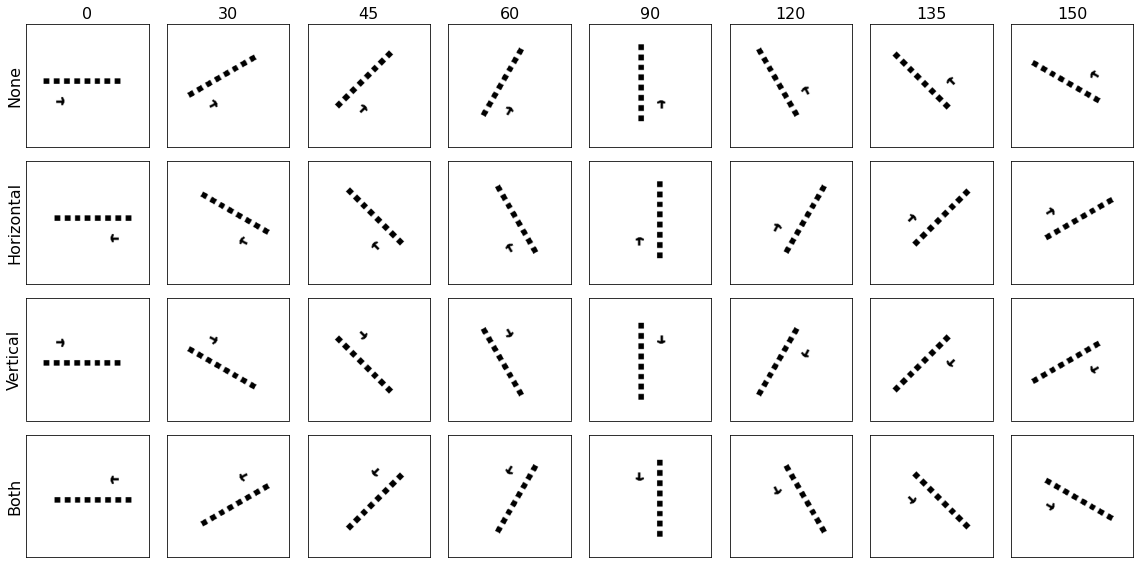

In [9]:

relation = ABOVE_BELOW_RELATION
distance_endpoints = (30, 80)
N_examples = 1
seed = 33
display(Markdown('## Flipping Manipulation -- Above/Below'))

images = []

for rotate_angle in [0, 30, 45, 60, 90, 120, 135, 150]:
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))
    stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=rotate_angle)

    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=False, transpose=False,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    triplets = triplet_generator(N_examples, normalize=False)
    images.append(triplets[0][0])

plot_flipped_versions(images, [0, 30, 45, 60, 90, 120, 135, 150],
    save_path='/Users/guydavidson/Downloads/flipping_above_below.png',
    text_kwargs=dict(fontsize=16))

## Flipping Manipulation -- Between

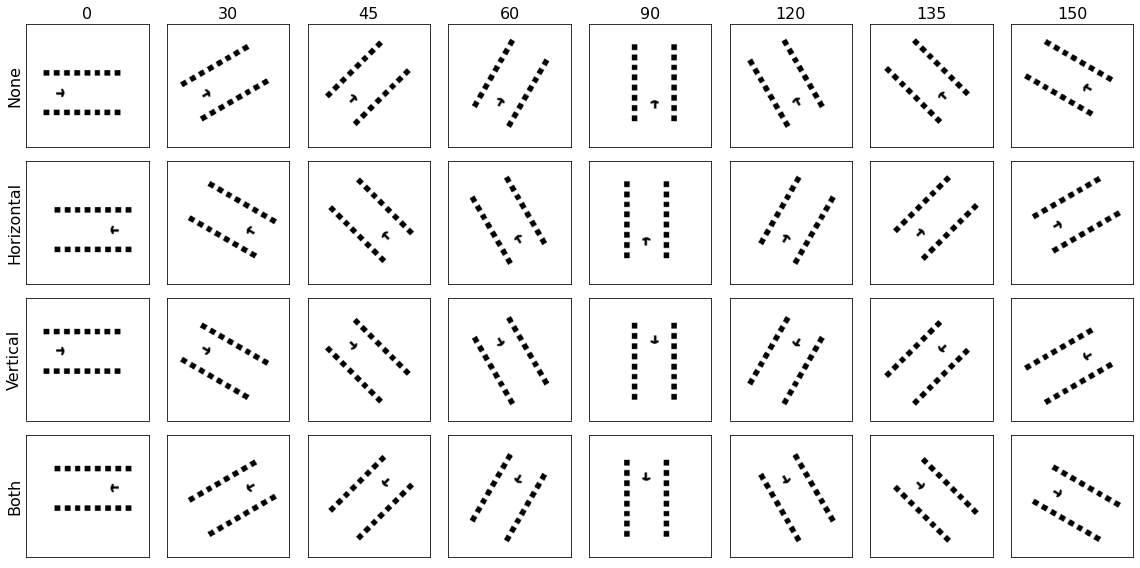

In [10]:

relation = BETWEEN_RELATION
distance_endpoints = (30, 80)
N_examples = 1
TRIPLET_INDEX = 0

display(Markdown('## Flipping Manipulation -- Between'))

images = []

for rotate_angle in [0, 30, 45, 60, 90, 120, 135, 150]:
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))
    stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=rotate_angle)
    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=True, transpose=False,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    triplets = triplet_generator(N_examples, normalize=False)
    images.append(triplets[0][TRIPLET_INDEX])



plot_flipped_versions(images, [0, 30, 45, 60, 90, 120, 135, 150],
    save_path='/Users/guydavidson/Downloads/flipping_between.png',
    text_kwargs=dict(fontsize=16))

## Flipping Manipulation -- Between

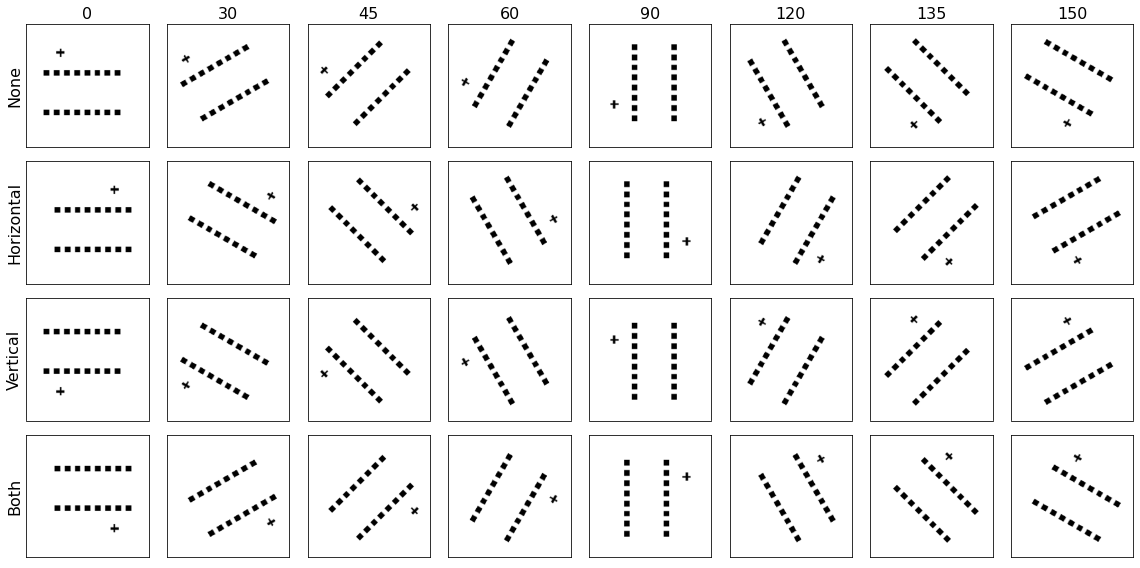

In [11]:

relation = BETWEEN_RELATION
distance_endpoints = (30, 80)
N_examples = 1
TRIPLET_INDEX = 2

display(Markdown('## Flipping Manipulation -- Between'))

images = []

for rotate_angle in [0, 30, 45, 60, 90, 120, 135, 150]:
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))
    stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=rotate_angle)

    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=True, transpose=False,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    triplets = triplet_generator(N_examples, normalize=False)
    images.append(triplets[0][TRIPLET_INDEX])



plot_flipped_versions(images, [0, 30, 45, 60, 90, 120, 135, 150],
    save_path='/Users/guydavidson/Downloads/flipping_outside.png',
    text_kwargs=dict(fontsize=16))

# Diagonal Above/Below

## color bar | above_below | 45 degrees

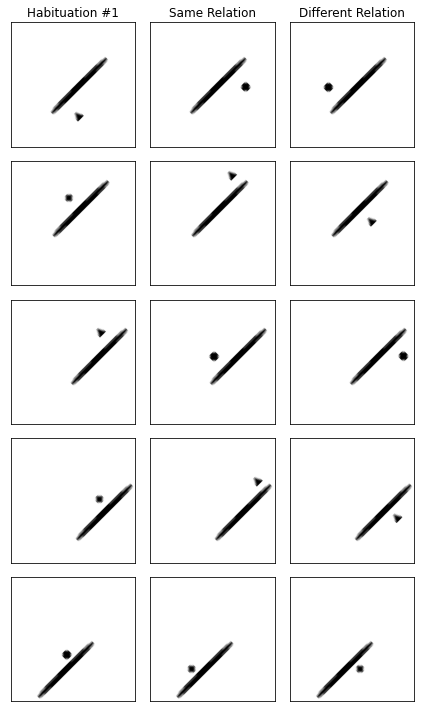

----

In [12]:
relation = ABOVE_BELOW_RELATION
distance_endpoints = (30, 80)
N_examples = 5

display(Markdown('# Diagonal Above/Below'))

# distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

rotate_angle = 45
for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
    
    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=False,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
    # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
    title = f'{generator_name} | {relation} | {rotate_angle} degrees'
    display(Markdown(f'## {title}'))
    triplets = triplet_generator(N_examples, normalize=False)
    plot_triplets(triplets)
    display(Markdown('----'))
    break


  0%|          | 0/8 [00:00<?, ?it/s]

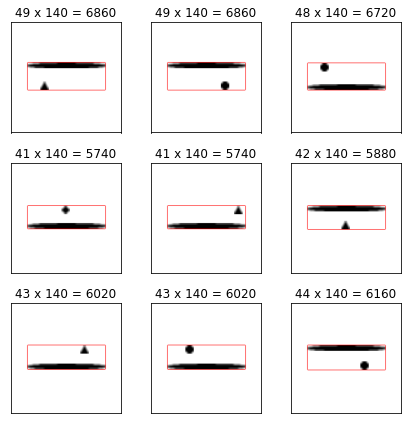

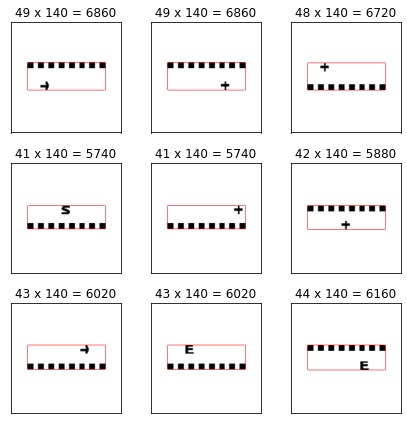

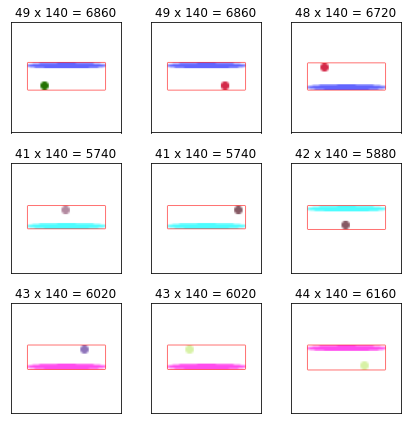

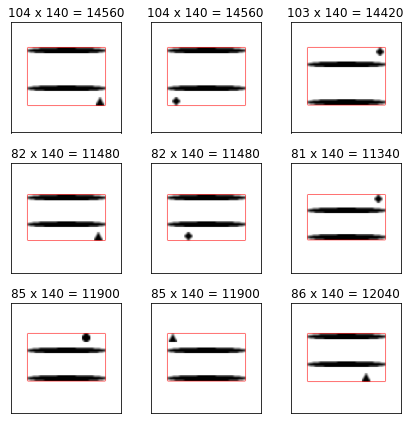

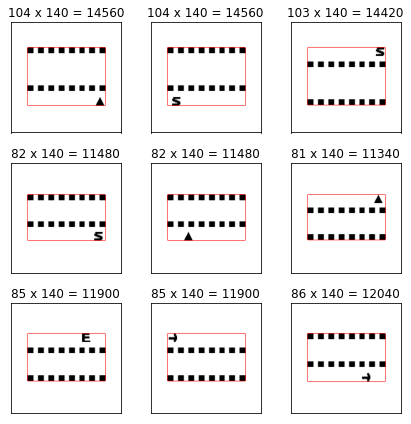

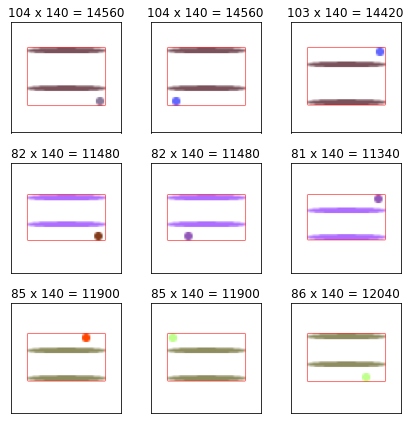

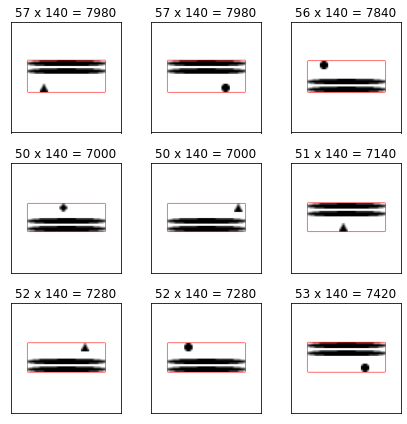

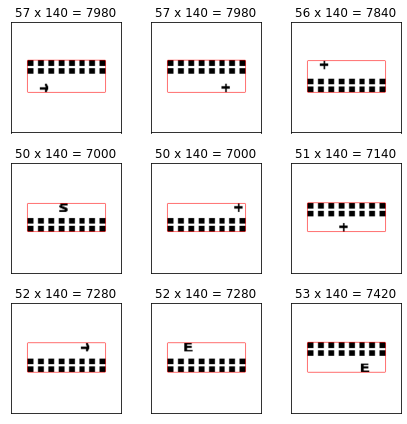

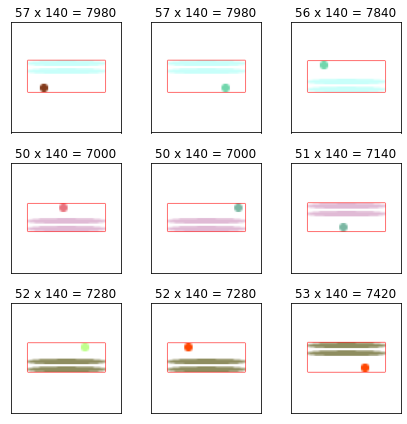

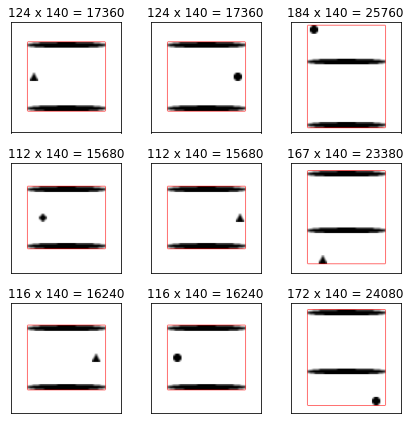

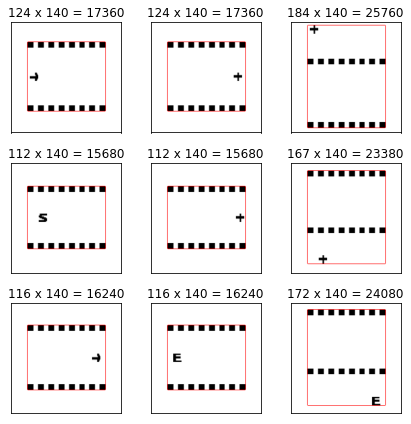

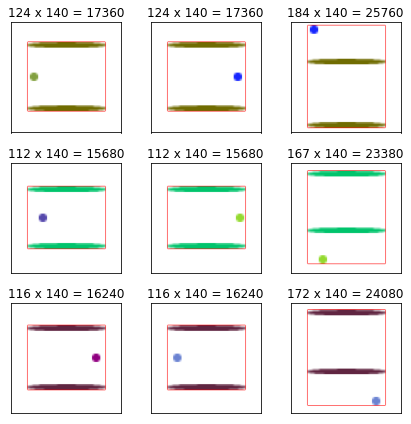

In [13]:
N_examples = 3
ANGLES = [0, 30, 45, 60, 90, 120, 135, 150]

rotate_angle = 0
n_habituation_stimuli = 1

OPTION_SET = (
    (ABOVE_BELOW_RELATION, BETWEEN_RELATION),
    (False, True),
    (False, True),
    # [1, 4],
    # ANGLES
) 

total_options = np.prod([len(v) for v in OPTION_SET])
option_iter = itertools.product(*OPTION_SET)

# for relation, two_reference_objects, adjacent_reference_objects, n_habituation_stimuli, rotate_angle in tqdm(option_iter, total=total_options):
for relation, two_reference_objects, adjacent_reference_objects in tqdm(option_iter, total=total_options):
    if (relation == ABOVE_BELOW_RELATION) and not two_reference_objects and adjacent_reference_objects:
        continue

    if (relation == BETWEEN_RELATION) and ((not two_reference_objects) or adjacent_reference_objects):
        continue

    distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

    for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=two_reference_objects,
            adjacent_reference_objects=adjacent_reference_objects,
             n_habituation_stimuli=n_habituation_stimuli,
            track_centroids=True,
            **BASELINE_TRIPLET_KWARGS)

        triplets = triplet_generator(N_examples, normalize=False)
        plot_cropped_centered_triplets(triplets)


## Comparing 90 degree rotated to transposed stimuli

# Above/Below

## Baseline | one ref

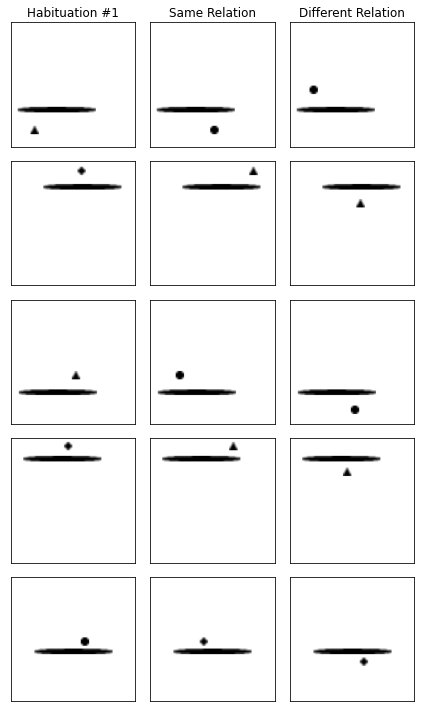

----

## Baseline | one ref

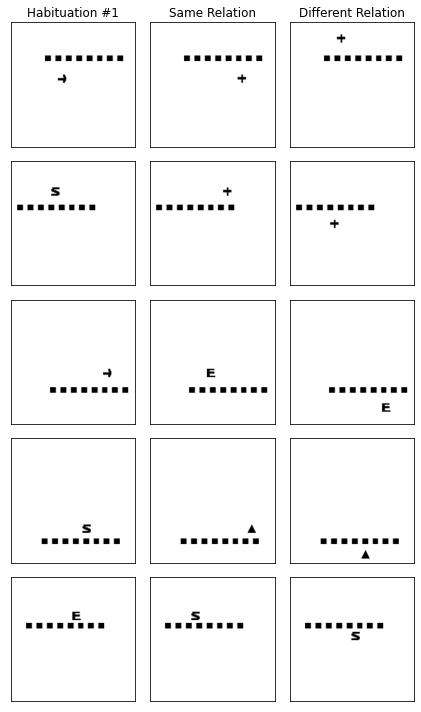

----

## Baseline | one ref

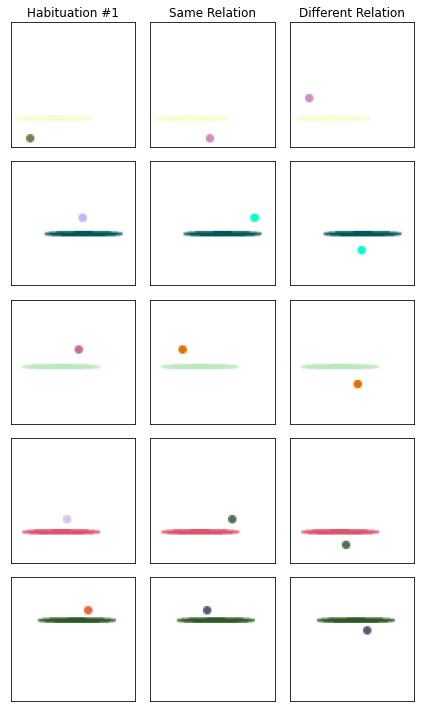

----

## Rotated 90 degrees | one ref

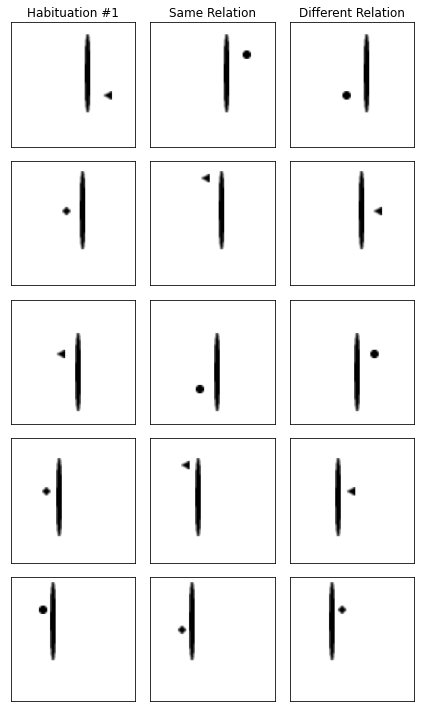

----

## Rotated 90 degrees | one ref

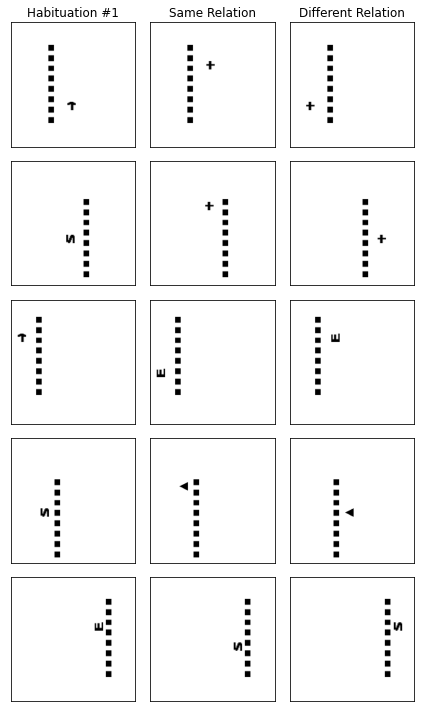

----

## Rotated 90 degrees | one ref

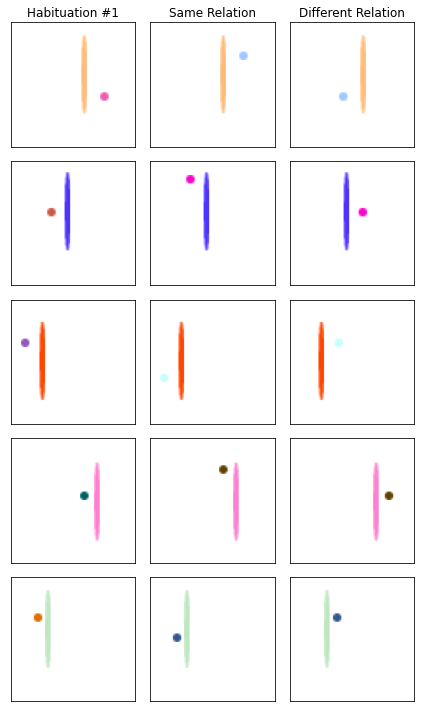

----

## Transposed | one ref

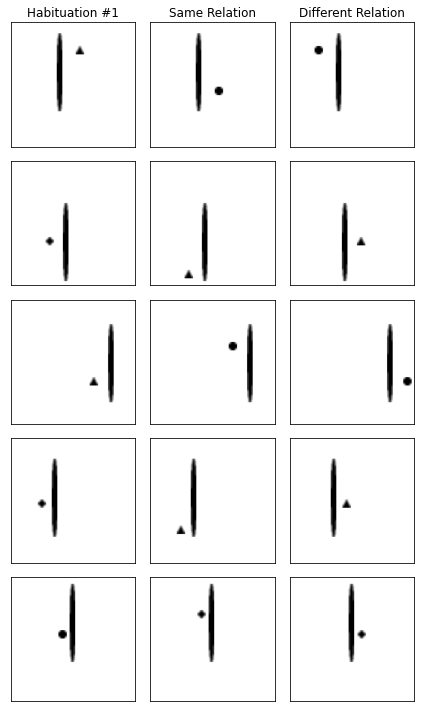

----

## Transposed | one ref

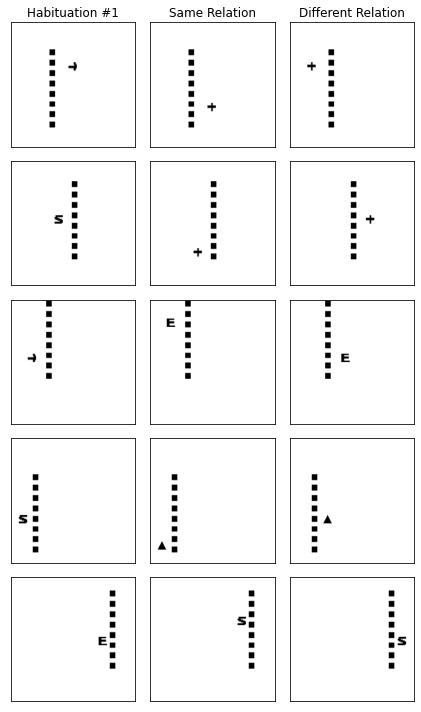

----

## Transposed | one ref

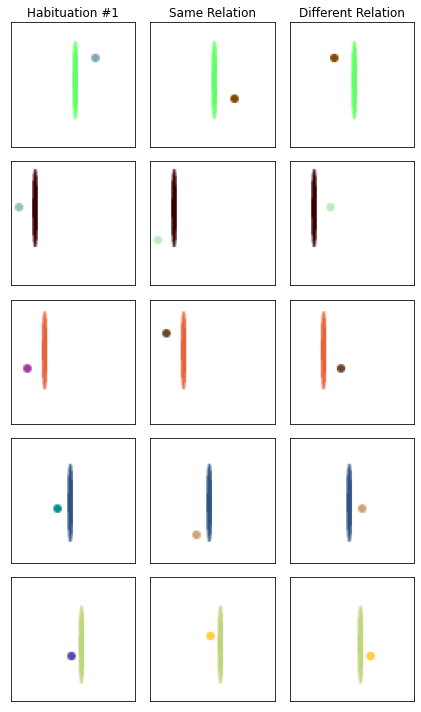

----

## Baseline | two refs | non-adjacent refs

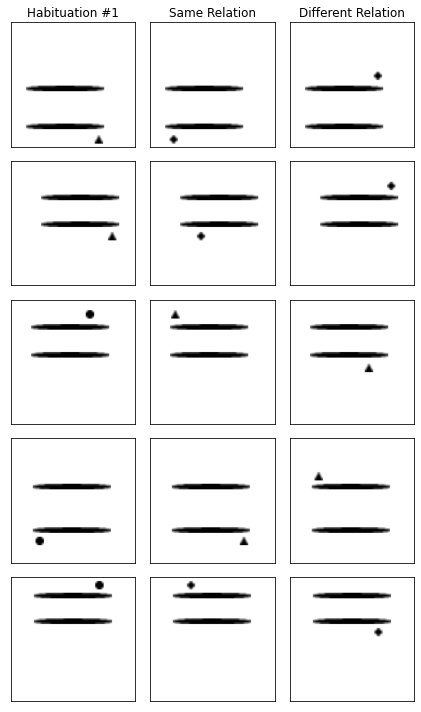

----

## Baseline | two refs | non-adjacent refs

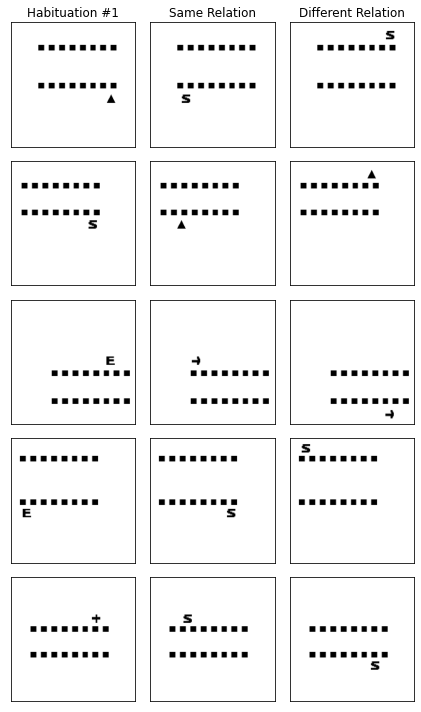

----

## Baseline | two refs | non-adjacent refs

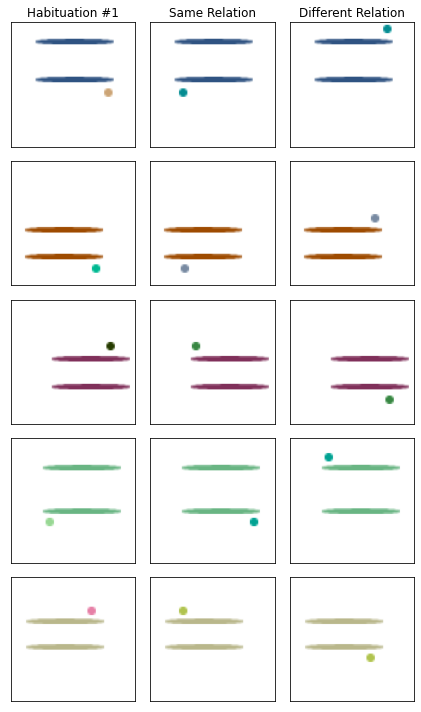

----

## Rotated 90 degrees | two refs | non-adjacent refs

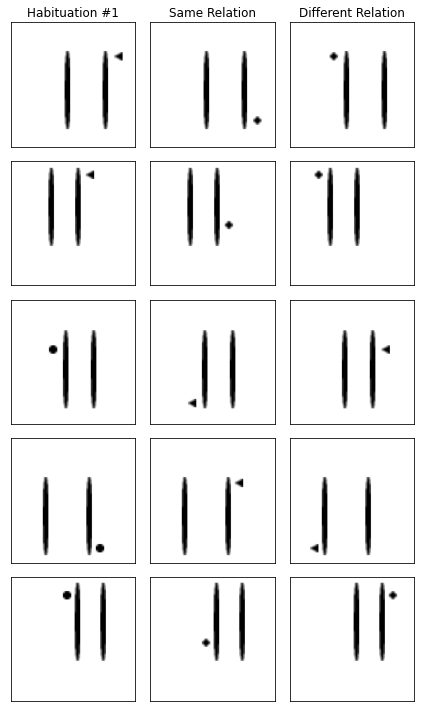

----

## Rotated 90 degrees | two refs | non-adjacent refs

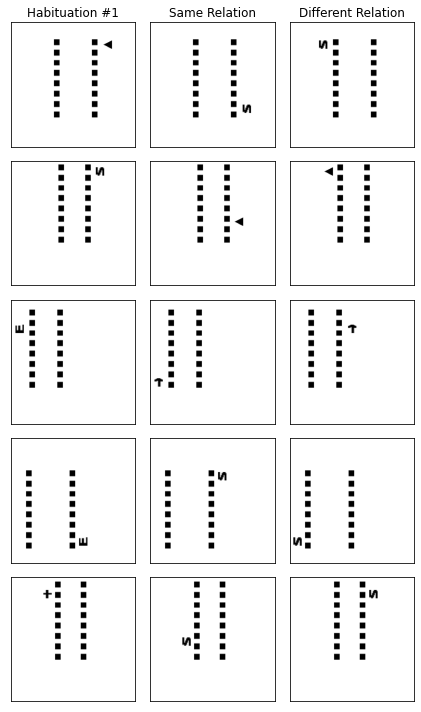

----

## Rotated 90 degrees | two refs | non-adjacent refs

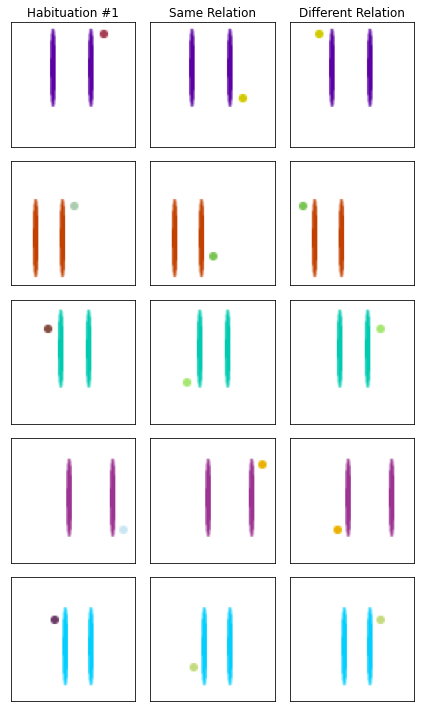

----

## Transposed | two refs | non-adjacent refs

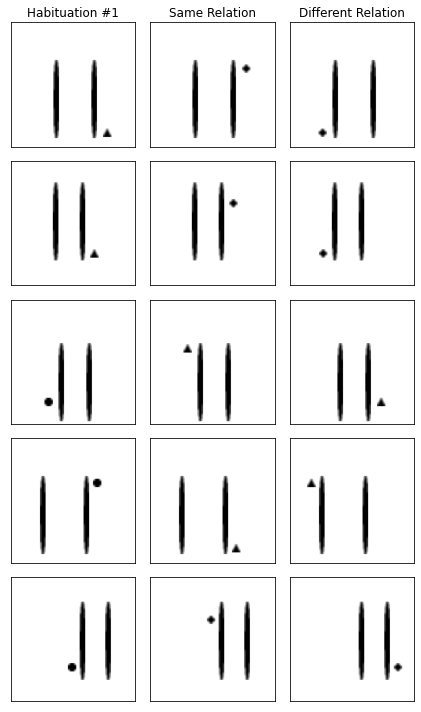

----

## Transposed | two refs | non-adjacent refs

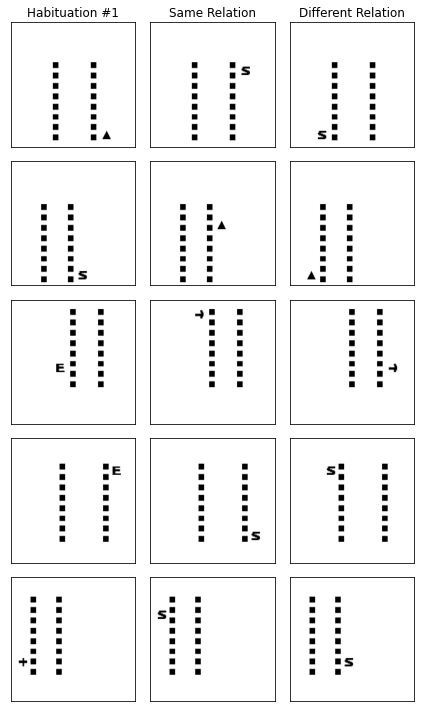

----

## Transposed | two refs | non-adjacent refs

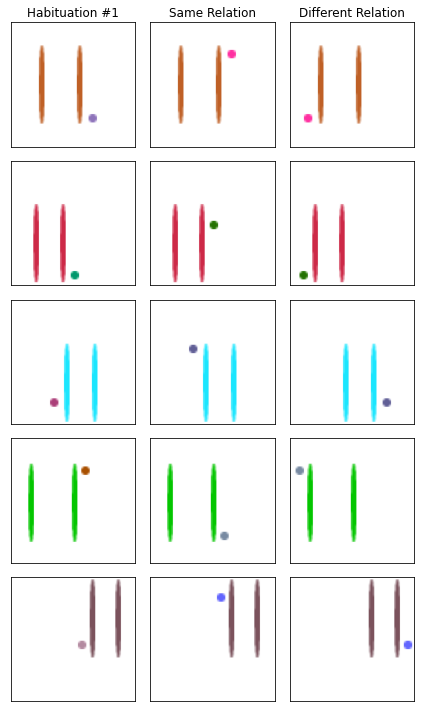

----

## Baseline | two refs | adjacent refs

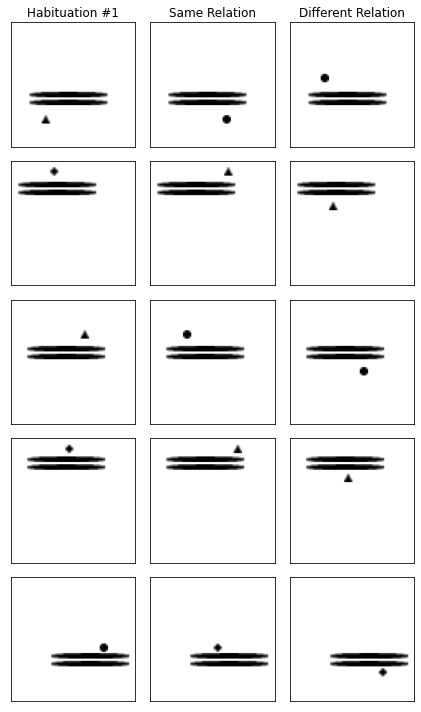

----

## Baseline | two refs | adjacent refs

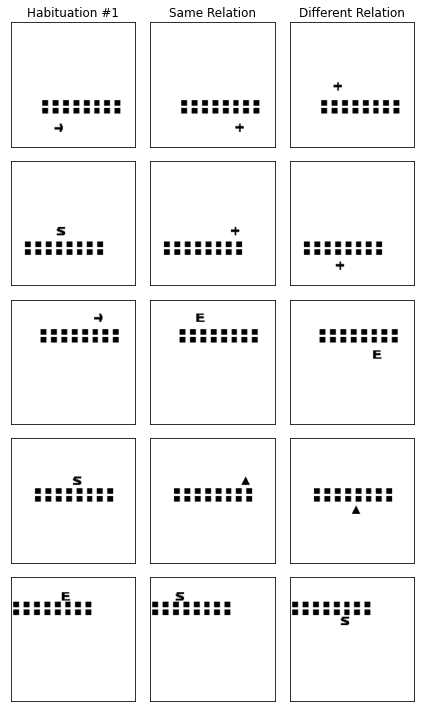

----

## Baseline | two refs | adjacent refs

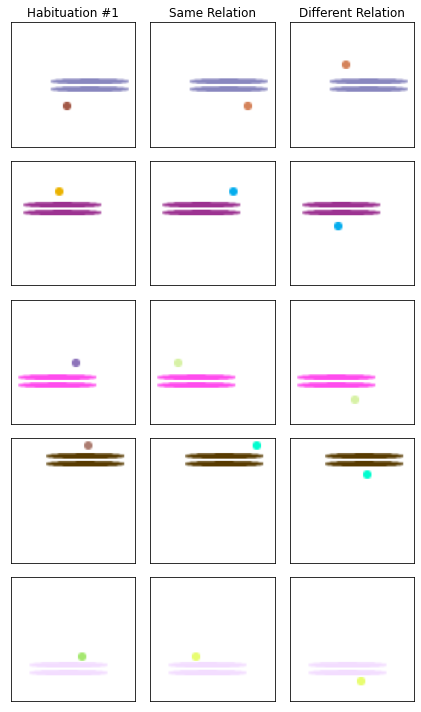

----

## Rotated 90 degrees | two refs | adjacent refs

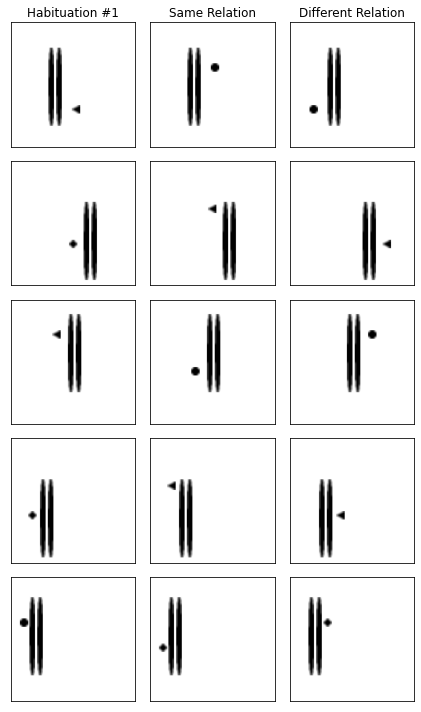

----

## Rotated 90 degrees | two refs | adjacent refs

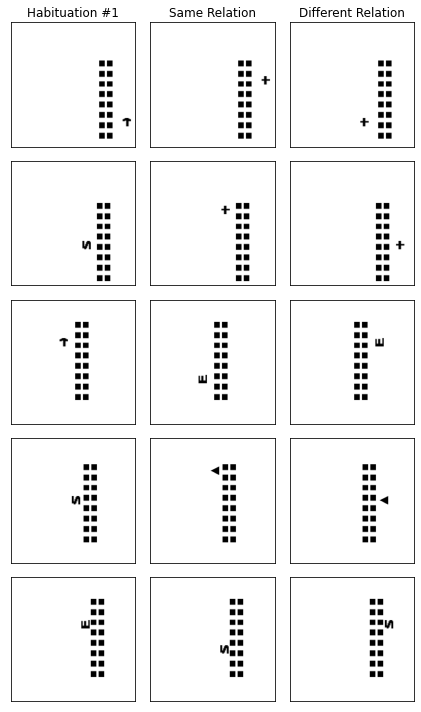

----

## Rotated 90 degrees | two refs | adjacent refs

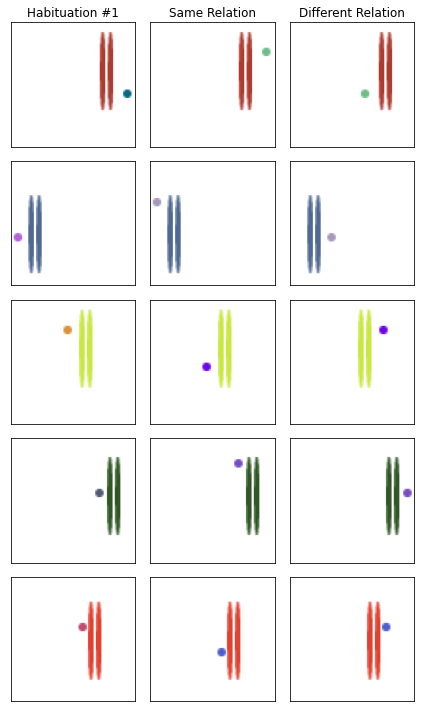

----

## Transposed | two refs | adjacent refs

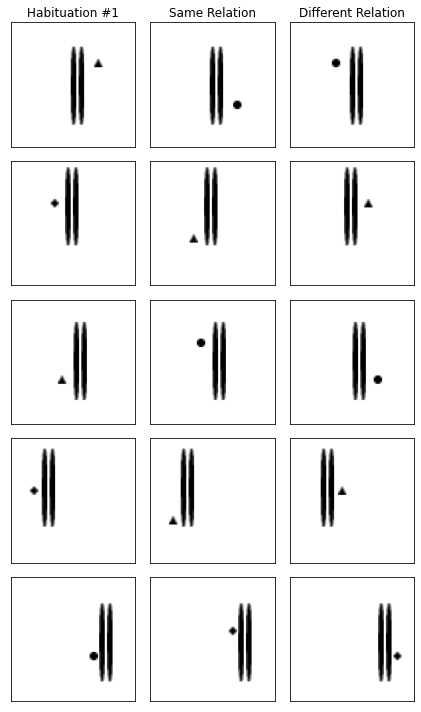

----

## Transposed | two refs | adjacent refs

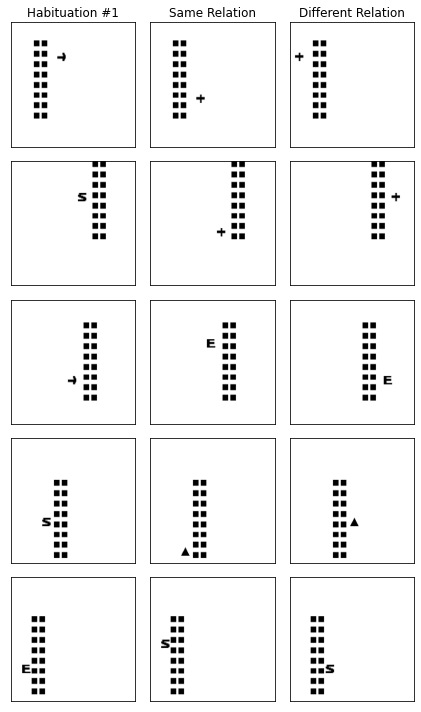

----

## Transposed | two refs | adjacent refs

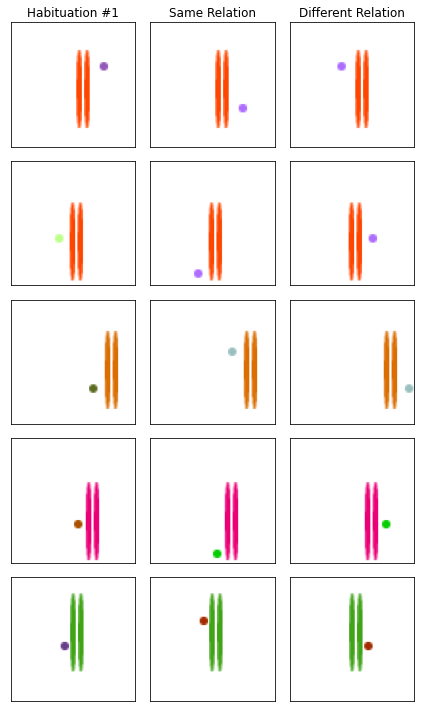

----

In [14]:
relation = ABOVE_BELOW_RELATION
N_examples = 5

display(Markdown('# Above/Below'))

for two_reference_objects in (False, True):
    for adjacent_reference_objects in (False, True):
        if not two_reference_objects and adjacent_reference_objects:
            continue

        distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

        for rotate_angle, transpose, name in ((0, False, 'Baseline'),  (90, False, 'Rotated 90 degrees'), (0, True, 'Transposed')):

            for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
                
                triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
                    relation=relation, two_reference_objects=two_reference_objects, transpose=transpose,
                    adjacent_reference_objects=adjacent_reference_objects, **BASELINE_TRIPLET_KWARGS)

                adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
                # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
                title = f'{name} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
                display(Markdown(f'## {title}'))
                triplets = triplet_generator(N_examples, normalize=False)
                plot_triplets(triplets)
                display(Markdown('----'))


# Above/Below

## Baseline | one ref

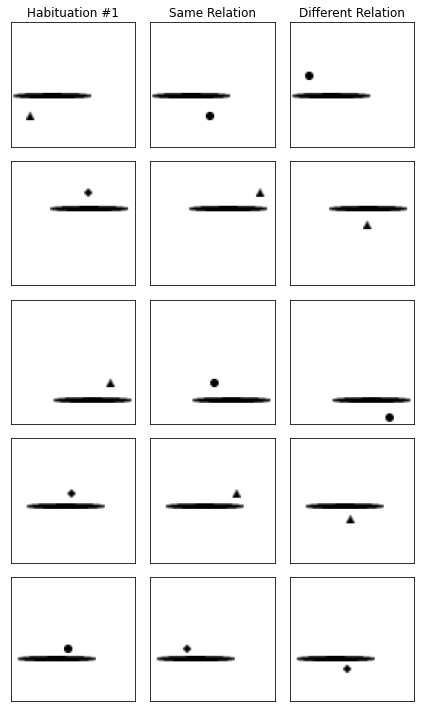

----

## Baseline | one ref

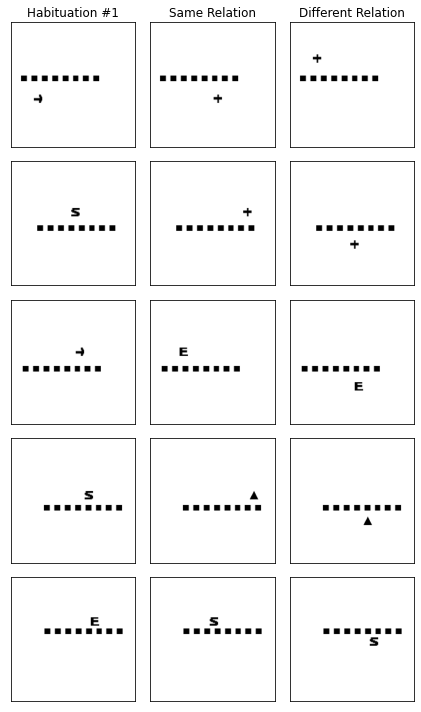

----

## Baseline | one ref

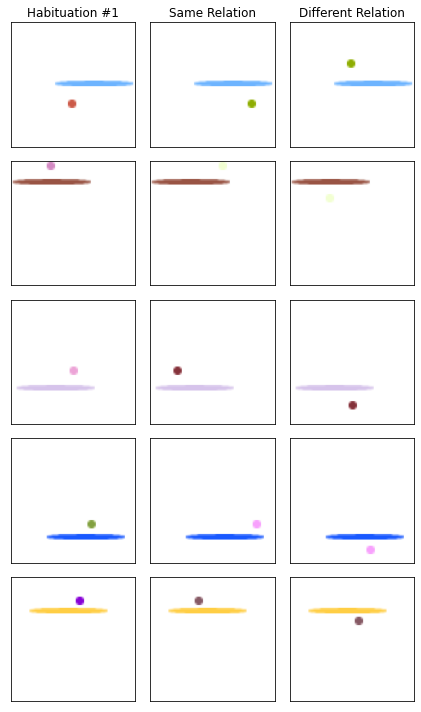

----

## Transposed and rotated | one ref

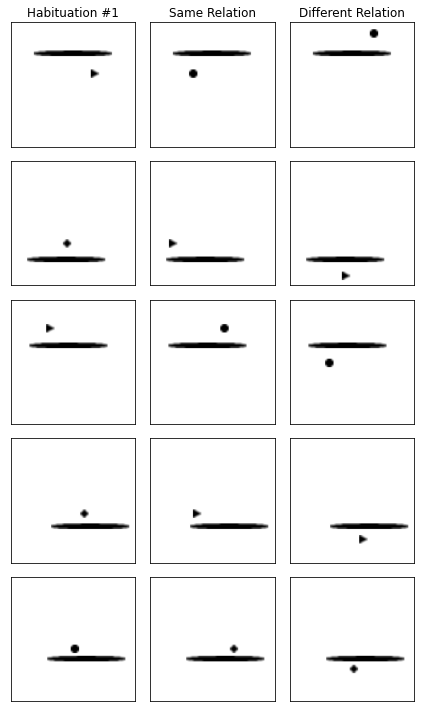

----

## Transposed and rotated | one ref

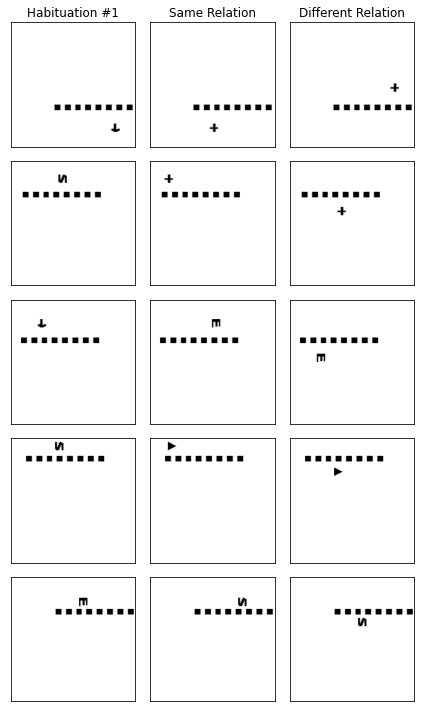

----

## Transposed and rotated | one ref

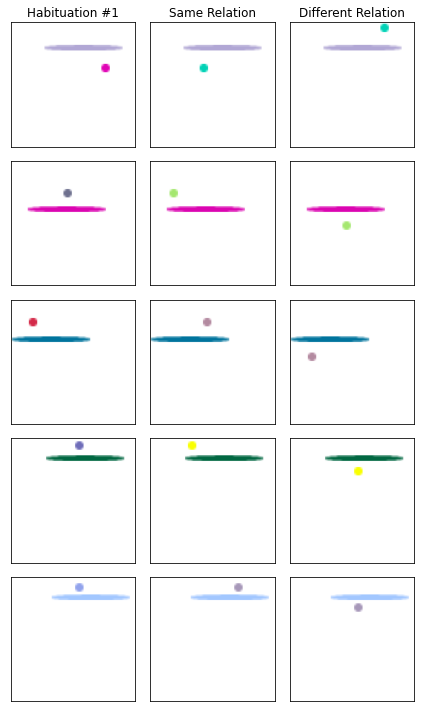

----

## Baseline | two refs | non-adjacent refs

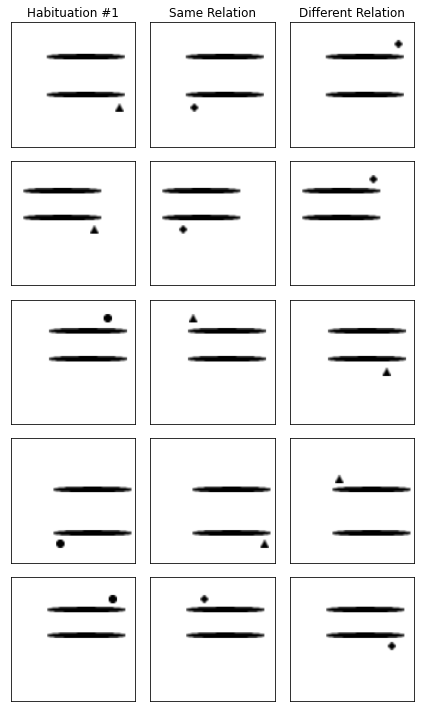

----

## Baseline | two refs | non-adjacent refs

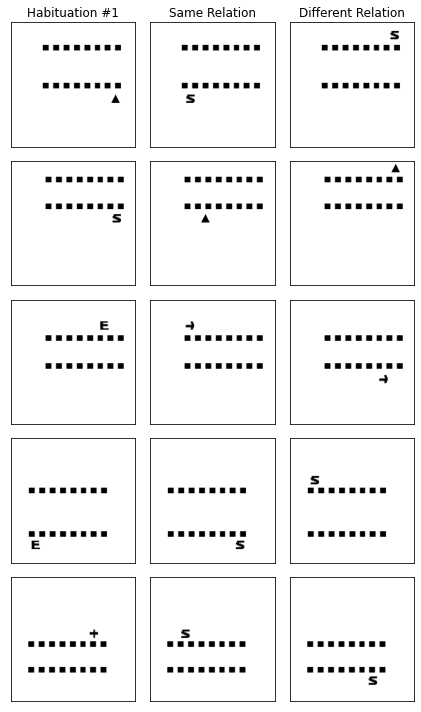

----

## Baseline | two refs | non-adjacent refs

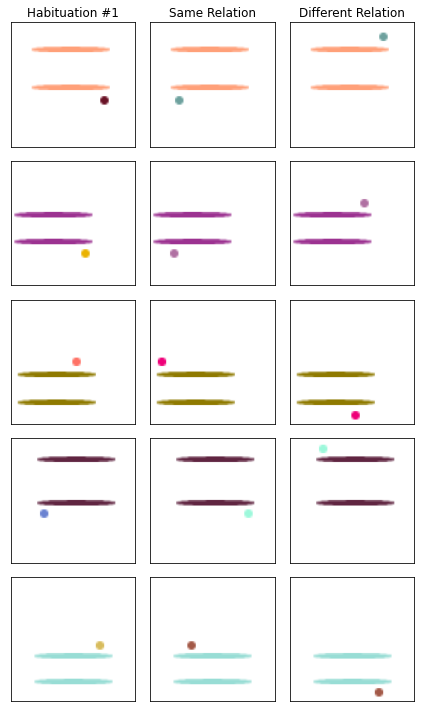

----

## Transposed and rotated | two refs | non-adjacent refs

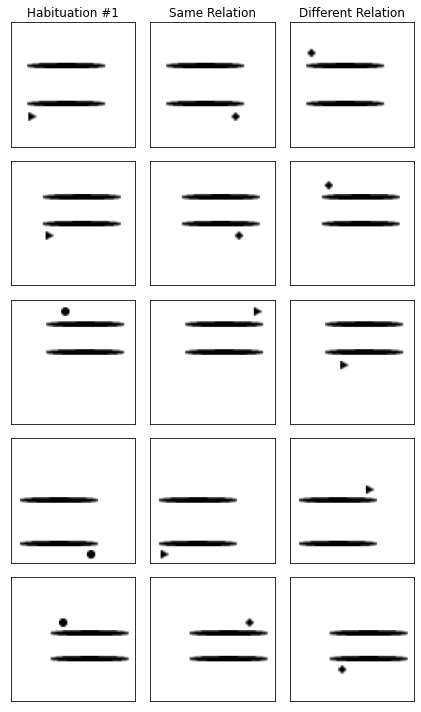

----

## Transposed and rotated | two refs | non-adjacent refs

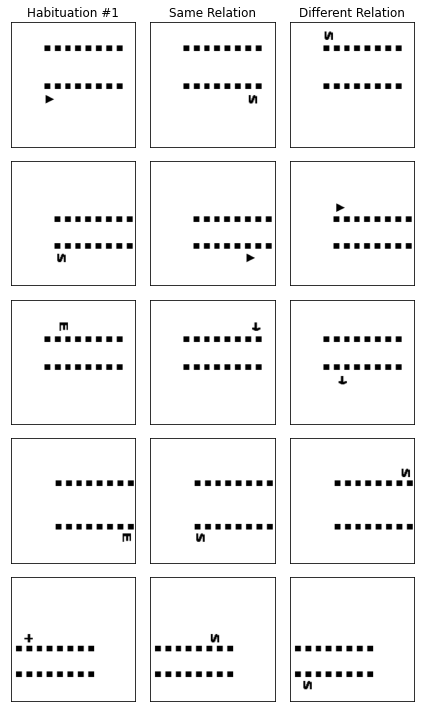

----

## Transposed and rotated | two refs | non-adjacent refs

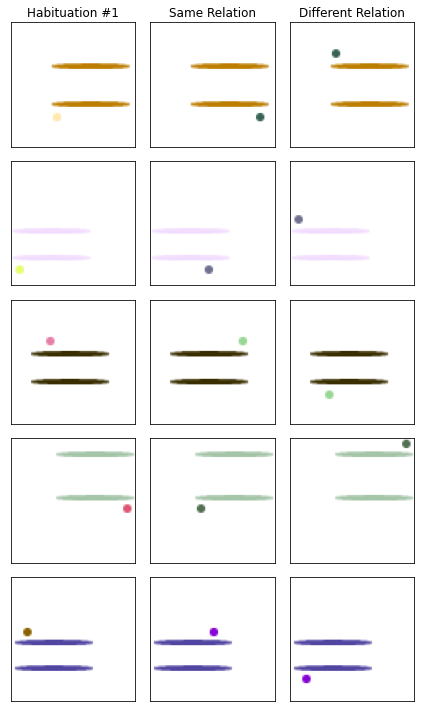

----

## Baseline | two refs | adjacent refs

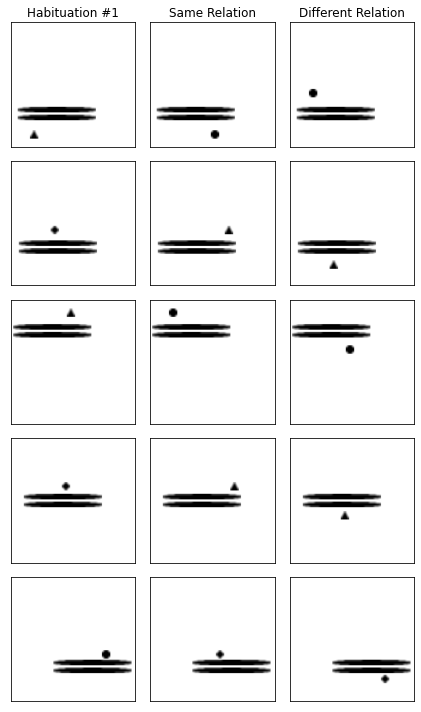

----

## Baseline | two refs | adjacent refs

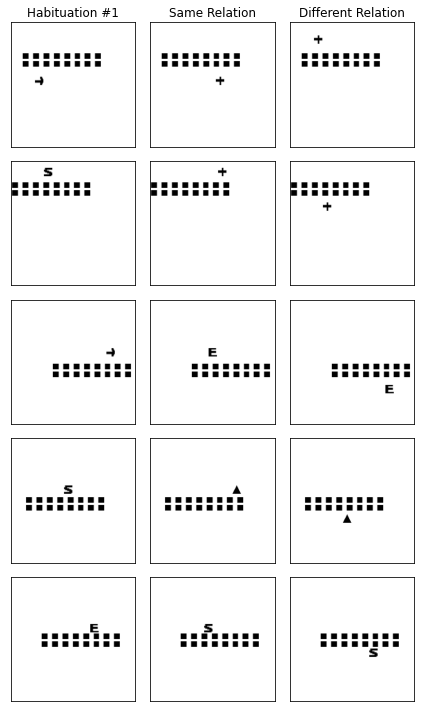

----

## Baseline | two refs | adjacent refs

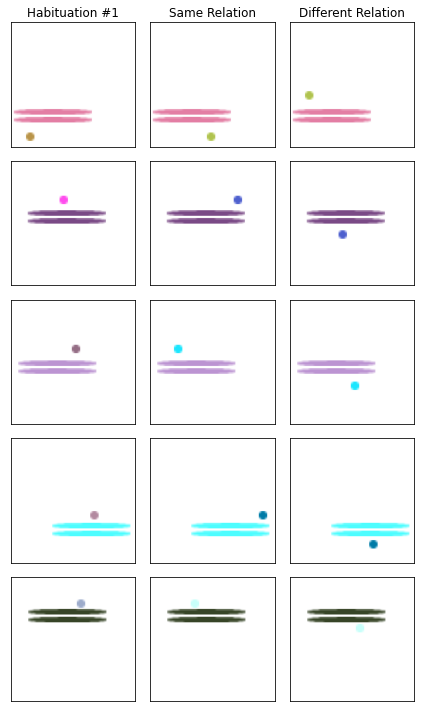

----

## Transposed and rotated | two refs | adjacent refs

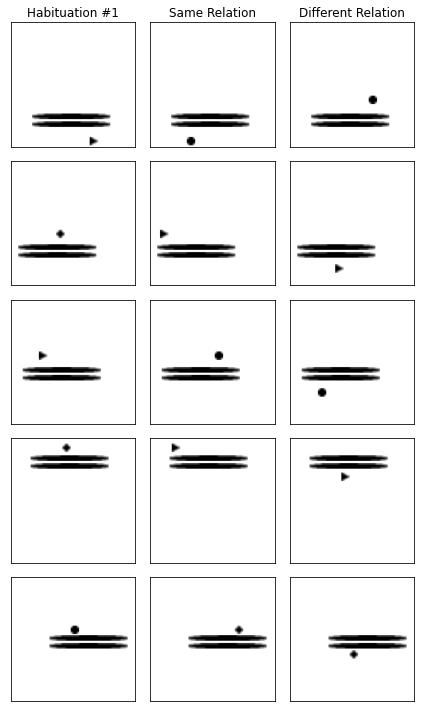

----

## Transposed and rotated | two refs | adjacent refs

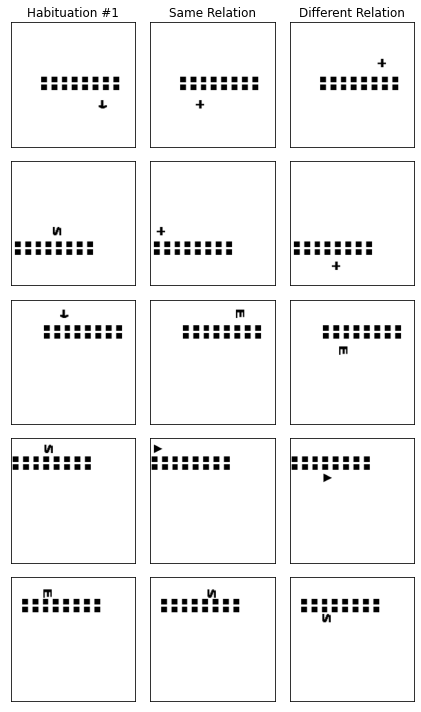

----

## Transposed and rotated | two refs | adjacent refs

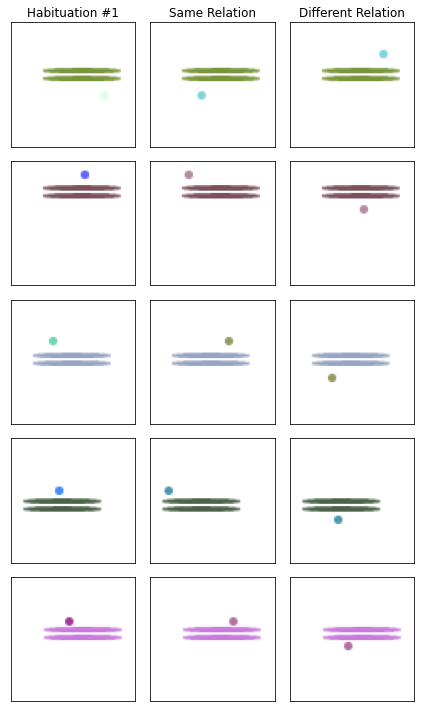

----

In [15]:
relation = ABOVE_BELOW_RELATION
N_examples = 5

display(Markdown('# Above/Below'))

for two_reference_objects in (False, True):
    for adjacent_reference_objects in (False, True):
        if not two_reference_objects and adjacent_reference_objects:
            continue

        distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

        for rotate_angle, transpose, name in ((0, False, 'Baseline'), (90, True, 'Transposed and rotated')):

            for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
                
                triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
                    relation=relation, two_reference_objects=two_reference_objects, transpose=transpose,
                    adjacent_reference_objects=adjacent_reference_objects, **BASELINE_TRIPLET_KWARGS)

                adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
                # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
                title = f'{name} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
                display(Markdown(f'## {title}'))
                triplets = triplet_generator(N_examples, normalize=False)
                plot_triplets(triplets)
                display(Markdown('----'))
